<a href="https://colab.research.google.com/github/TheClassicTechno/theclassictechno.github.io/blob/main/project2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENGR 76 Project 2a: Getting sound going, and on-off keying

_Due: May 17, 2024 at 4 PM_

<font color='blue'>**julih**</font>     @stanford.edu

In Project 1, you implemented a full-fledged image compressor that incorporated ideas like Huffman coding, frequency domain filtering, and quantization. The overall goal of the project was to explore ways to store information *efficiently* with bits. In Project 2, we will explore ways to communicate bits of information *reliably* over a noisy communication channel.

<!--Our goal this week is to get ourselves set up with a basic on-off keying system that can communicate digital messages from your speaker to your microphone.-->

<div class="alert alert-info" style="color:black;">
    <p>
        <strong>Where we are in Project 2.</strong>
        This week, we'll implement an on-off keying modulator, which converts digital messages into sounds that can be transmitted from your speaker to your microphone, and an energy detection demodulator that recovers the original message from the received audio signal. In subsequent weeks, we'll work on filtering noise and implementing error-correcting codes to make our system more robust. Project 2d (not shown here) will be more open-ended, similar to Project 1d.
    </p>
    <p style="text-align: center;">
        <img src="img/proj2a-where.png" style="height: 84px;" />
    </p>
</div>

**A note on how long this might take.** The tasks this week are quite simple. However, how easy it is to get going physically can be very system-dependent—not just on how "good" your devices are, but also on things like the acoustics of your room, the distance between your speaker and microphone, "intelligent" things your speaker and microphone try to do, interference patterns your speakers might produce, and not to mention the volume settings of your speaker and microphone. For this reason, we expect a lot of time this week to be spent negotiating with your speaker and microphone to get things going.

**Simulation Channel:** You will test your implementation on a software-simulated noisy channel, and it is important to make sure your code is running correctly on the simulated channel before moving forward to the physical ones. Hopefully, this can reduce the amount of time on debugging your hardware settings. If you hit any difficulties, please be in touch with us. You should earn a significant portion of the points if your code runs correctly on the software-simulated channel. Each question is clearly marked with **Simulated Channel** or **Physical Channel** to differentiate between the two. Even if you face hardware issues, and have to visit OHs to fix these, you should try to finish all questions marked with Simulated Channel before visiting.

**Hardware Issues:** It is possible that you face issues in playing and recording sounds on your device this week. We will release a set of common fixes which you should try if you face such issues. If you still face issues, it is important that you come to office hours, so that we can help you solve these issues. In the worst case, when even we are not able to fix these issues, we will also have a few spare laptops available during some of the office hours which you can use to run your code. We will release the availability of these laptops. It is important that you successfully test your code on the simulation channel before coming to office hours.

<div class="alert alert-danger" style="color: black;"><strong>Warning:</strong> This project involves playing lots of sounds on your speaker, and because your microphone needs to hear those sounds traveling through the air, you can't do it through headphones (or a loopback). We advise against doing this late at night when your roommates or neighbors are sleeping, or in an environment that might annoy other people.

Some students face problems when they hear sounds at high frequencies. You should test your code only at frequencies with which you are comfortable.
</div>

<div class="alert alert-info" style="color: black;"><strong>Answer formatting:</strong> As usual, we've left <code>&gt; YOUR ANSWER HERE</code> in cells where we want you to type in the answer. To do so, double-click the cell, and please leave the <code>&gt;</code> there (and start each paragraph with <code>&gt;</code>) so that the blockquote bar on the left remains next to your answer.</div>

In [ ]:
# Packages you should already have installed, to be imported:

import numpy as np
π = np.pi

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)  # make the graphs wider

from numpy.random import default_rng
rng = default_rng()

from simulated_channel import simulated_channel

# Part 0: Install `sounddevice`

We'll need the `sounddevice` package. To install it, run the following command in a new console or terminal:
```
pip install sounddevice
```
(You can also run this in a cell. Just be sure to delete the cell once you've run it, because you only need to install it once! If you use a different Python package manager, install it using that instead.) If you install this via terminal, you may need to restart the kernel before importing it.

In [ ]:
# after you install `sounddevice`, this import should work:
import sounddevice as sd
sd.default.channels = 1

<div class="alert alert-warning"><strong>Windows Subsystem for Linux users:</strong> WSL doesn't have native access to your sound card, so this won't work on WSL. You should install Python and Jupyter on Windows, and run this on Windows.</div>

# Part 1: Play and record pure tones (15 points)

A **pure tone** is a sound with a purely sinusoidal waveform. It's so called because, in the frequency domain (think back to Project 1b), it would have just a single frequency component, with no harmonics.

Our goal in this part is to have the computer play a pure tone, and record itself playing the pure tone.

Recall that a pure sinusoid (in continuous time) of frequency $f$ is given by
$$\tilde x(t) = A \sin(2\pi f t).$$

Computers can't process continuous-time signals, so in practice, we represent audio signals as discrete-time signals, as if they were sampled at a sampling frequency $f_s$. That is, if we want to play a sinusoid with frequency $f$, we generate the signal, indexed by $n$,
$$x[n] = A \sin(2\pi f \cdot t[n]), \qquad t[n] = n T_s = \frac{n}{f_s},$$
where $T_s = 1/f_s$ is the sampling period. A common sampling rate is $f_s = 44.1\,\text{kHz}$, or 44,100 samples per second. (Humans can only hear frequencies up to about 20 kHz, so by the Nyquist–Shannon sampling theorem, this should capture all sounds of interest to humans.) **You should not need to change the sampling frequency $f_s$ anywhere in the project.**

<div class="alert alert-info" style="color: black;">
    <p><strong>Terminology relating to discrete-time signals.</strong>
    We sometimes use square brackets $x[n]$ to emphasize that signals are discrete-time, that is, that $n$ can only take integer values starting at 0.</p>
    <p>To be extra clear, we're using $\tilde x(\cdot)$, with a tilde ~ and round parentheses, to mark the continuous-time signal from which $x[\cdot]$ is derived. So $\tilde x(\cdot)$ and $x[\cdot]$ refer to different, but closely related, objects. (Using a modifier for the continuous-time signal is nonstandard—we're reserving the undecorated character for discrete-time here because this project is mostly about the sampled signals.)</p>
    <p>Because it's sometimes helpful to relate signals to their timestamp, we often need to keep track of a <em>time vector</em>, which we'll call $t[n]$. Then $t[n]$ just contains multiples of the sampling period, $t[0] = 0, t[1] = T_s, t[2] = 2T_s, \dots$, up to the end of the signal.</p>
    <p>Because computers can only represent finite sequences, we represent them as (1-D) vectors in NumPy. So <code>x[n]</code>, the <code>n</code>th element of the 1-D <code>np.ndarray</code> object (NumPy vector) <code>x</code>, contains the sample corresponding to $x(t)$ at time $t[n]$, that is, $x[n] = \tilde x(t[n])$.</p>
    <p>This can sometimes get confusing. You'll get used to it with time, but also don't hesitate to reach out to chat about this.</p>
</div>

In [ ]:
# feel free to play with these numbers and then re-run subsequent cells
tmax = 1.2                     # end of signal in time (seconds)
fs = 44100                     # sampling frequency, DO NOT CHANGE THE SAMPLING FREQUENCY!
f = 1000                       # frequency of tone
t = np.arange(0, tmax, 1/fs)   # time vector t[n]
x = np.sin(2*π*f*t)            # signal vector x[n]

### Plotting a signal

To plot the signal in terms of _time_ $t$ (in seconds), we pass the time vector `t` as the first argument to `plt.plot()`:

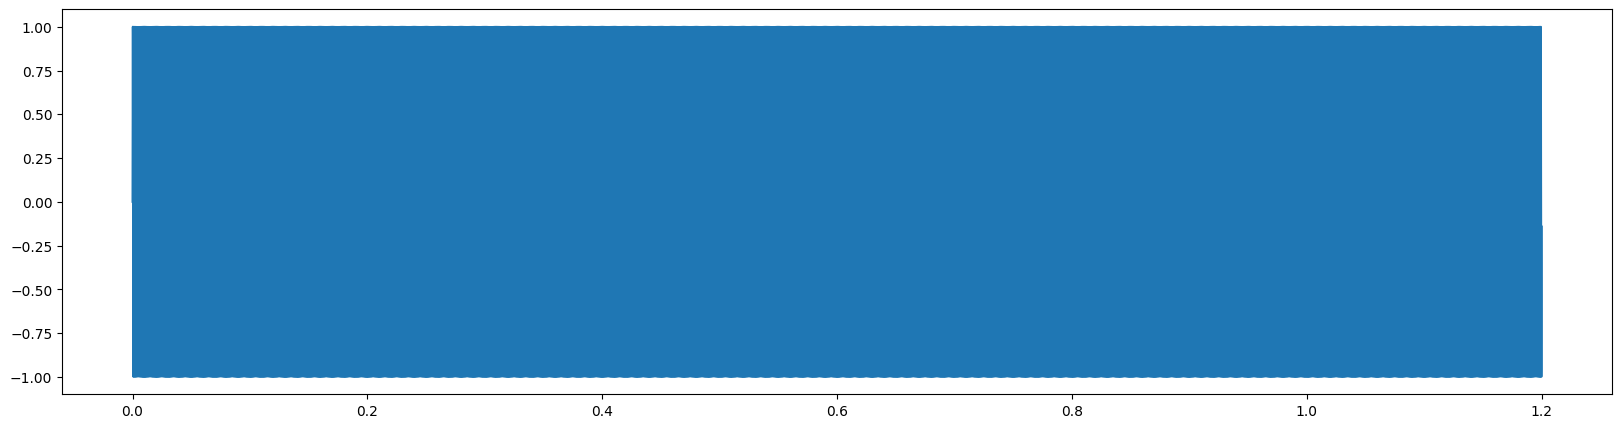

In [ ]:
# plot the whole signal in time
plt.plot(t, x)
plt.show()

Sometimes we might want to zoom in on a small portion of a signal to get a better look:

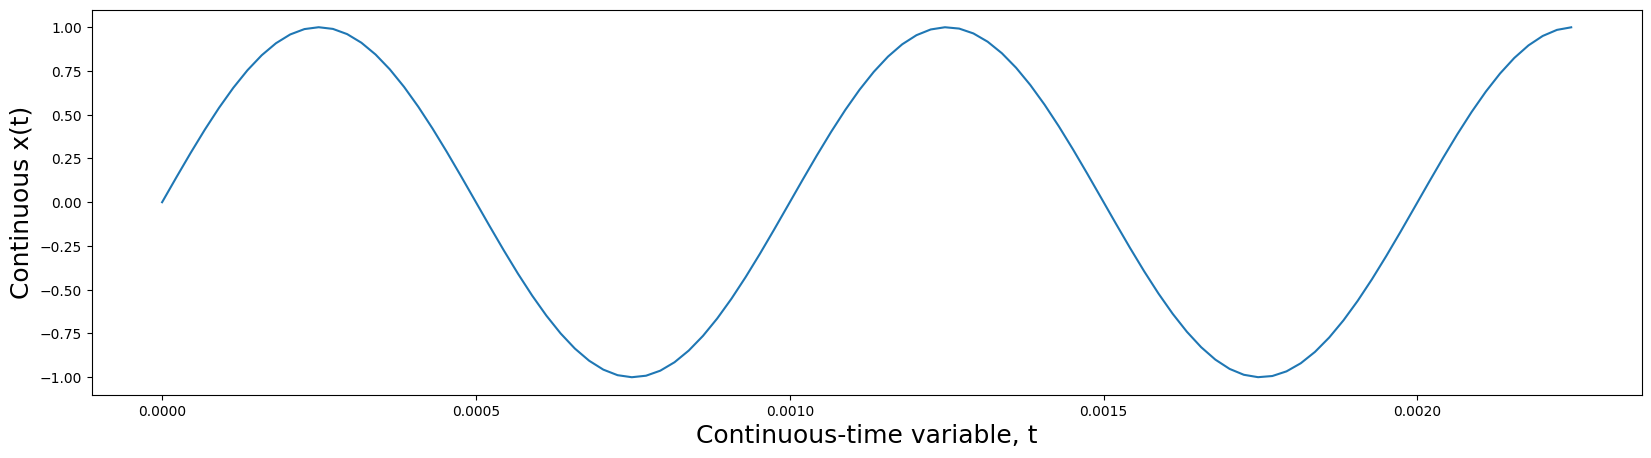

In [ ]:
# plot just the first 100 samples of the signal
plt.plot(t[0:100], x[0:100])
plt.xlabel('Continuous-time variable, t', size=18)
plt.ylabel('Continuous x(t)', size=18)
plt.show()

To better emphasize that `x[n]` is a discrete-time signal, we can use `plt.stem(t, x)` to better display the signal:

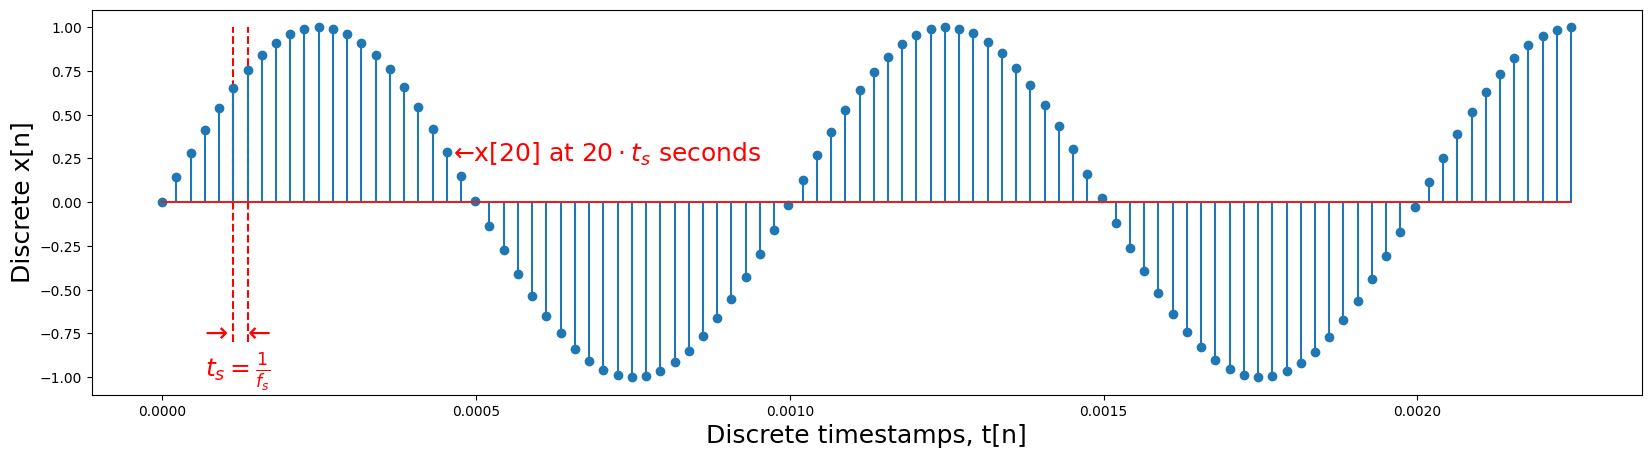

In [ ]:
plt.xlabel('Discrete timestamps, t[n]', size=18)
plt.ylabel('Discrete x[n]', size=18)

# label ts
plt.plot([t[5], t[5]], [-0.8, 1], color='red', linestyle='dashed')
plt.plot([t[6], t[6]], [-0.8, 1], color='red', linestyle='dashed')
plt.text(t[3], -0.8, "→", size=20, color='red')
plt.text(t[6], -0.8, "←", size=20, color='red')
plt.text(t[3], -1.0, r"$t_s = \frac{1}{f_s}$", size=18, color='red')

plt.text(t[20]+0.00001, 0.23, r"←x[20] at $20\cdot t_s$ seconds", size=18, color='red')

# display the discrete-time signal using plt.stem()
plt.stem(t[0:100], x[0:100])
plt.show()

### Simulated noisy channel

Prior to playing and recording the signals, we begin by simulating the microphone-speaker system. As we progress with our transmission system development, our standard procedure involves initial testing on the simulated channel to confirm proper code functionality. Only after validating on the simulated channel do we proceed to physical channels.  By testing your implementation on simulated channels, you can effectively isolate code-related issues from hardware-related ones.  Hopefully, this will save your debugging efforts.

In the simulated channel, we model the following 2 sources of randomness:
- A random delay in the received signal, due to the synchronization between the microphone and the speaker (you will see more details in the next section).
- The random noise on the signal.

When you apply `simulated_channel()` to the signal `x`, it will introduce perturbations to your signal and produce a noisy version of it:

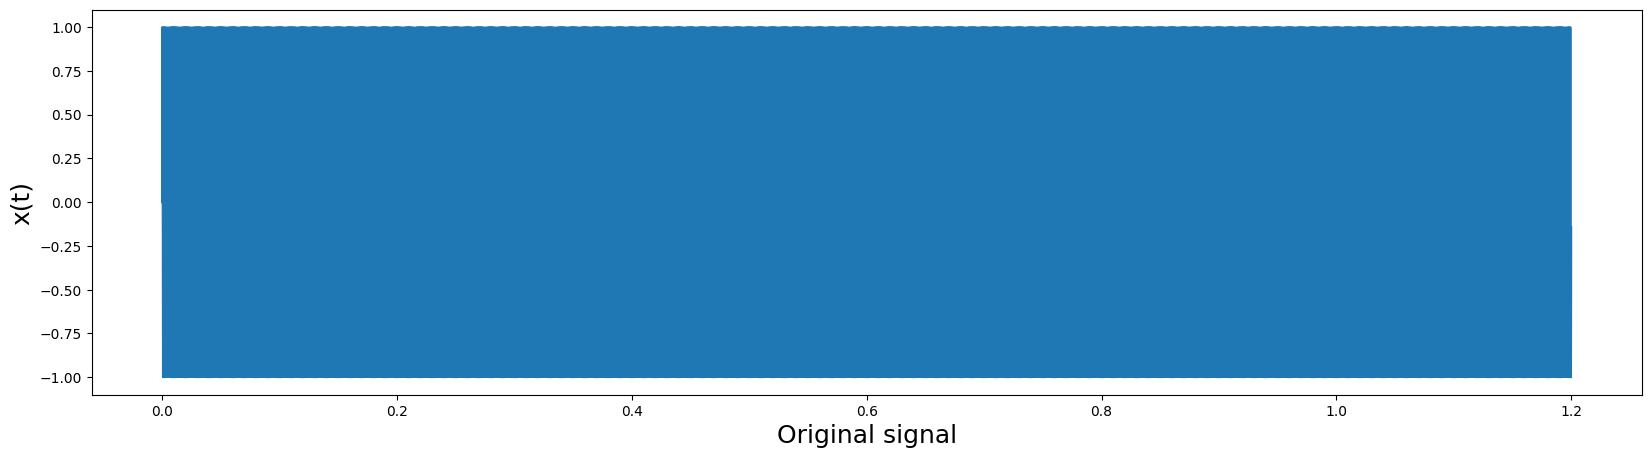

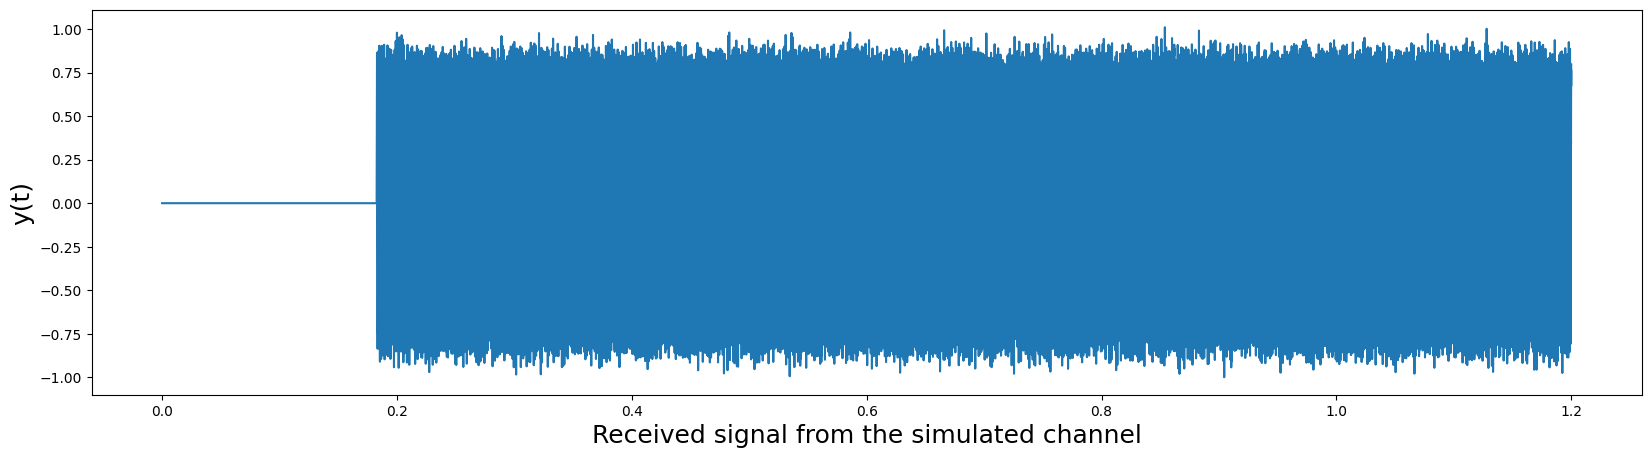

In [ ]:
# feel free to play with these numbers and then re-run subsequent cells
tmax = 1.2                     # end of signal in time (seconds)
fs = 44100                     # sampling frequency
f = 1000                       # frequency of tone
t = np.arange(0, tmax, 1/fs)   # time vector t[n]
x = np.sin(2*π*f*t)            # signal vector x[n]

# Plot the original signal
plt.plot(t, x)
plt.xlabel('Original signal', size=18)
plt.ylabel('x(t)', size=18)
plt.show()

# This simulates the transmission of the signal over your microphone speaker system.
y = simulated_channel(x)

# Now, let us plot the received signal.
plt.plot(t, y)
plt.xlabel('Received signal from the simulated channel', size=18)
plt.ylabel('y(t)', size=18)
plt.show()


Let's take a closer look:

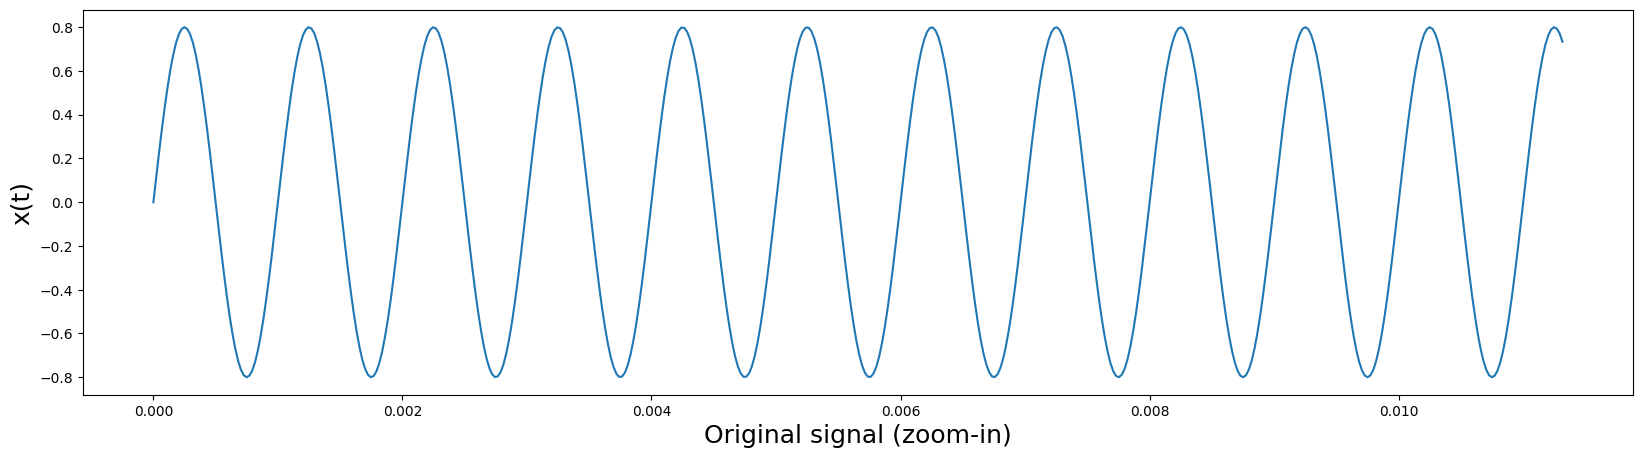

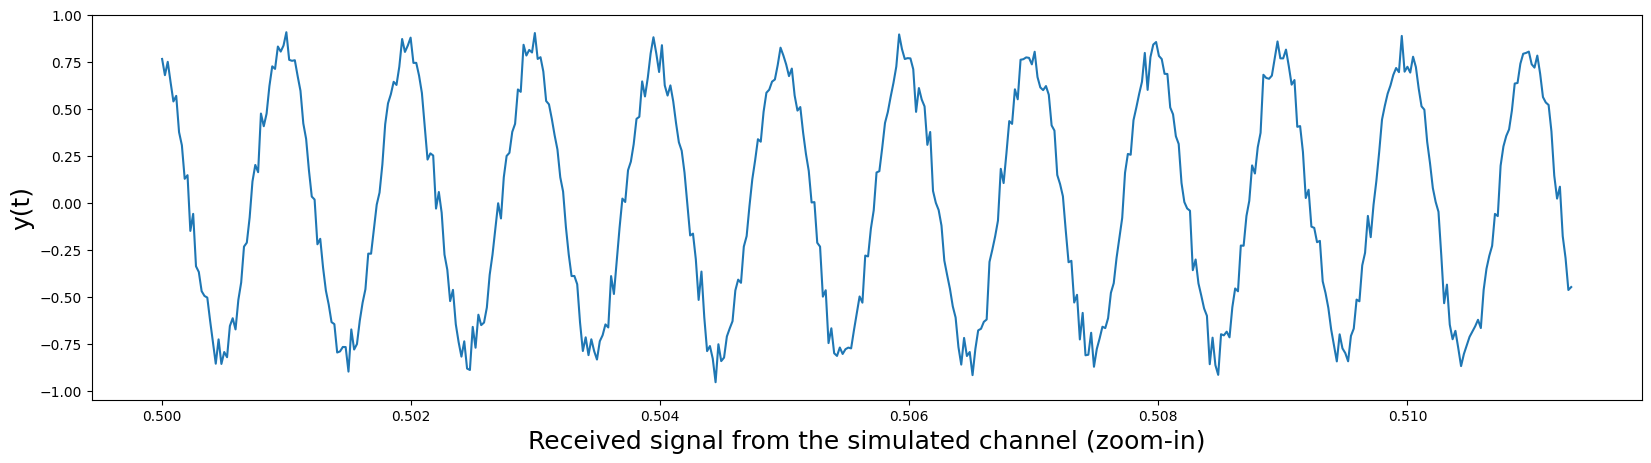

In [ ]:
# Plot the original signal
plt.plot(t[:500], x[:500])
plt.xlabel('Original signal (zoom-in)', size=18)
plt.ylabel('x(t)', size=18)
plt.show()

# Plot the received signal
plt.plot(t[fs//2:fs//2+500], y[fs//2:fs//2+500])
plt.xlabel('Received signal from the simulated channel (zoom-in)', size=18)
plt.ylabel('y(t)', size=18)
plt.show()

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 1.1. - Simulated Channel.</span> Roughly how long is the delay of the received signal from the simulated channel? Round your answer to the first decimal point.

_WHAT WE EXPECT:_ a short 1-sentence answer.

> The delay of the received signal from the simulated channel is around 0.2 seconds.

The delay in the received signal means, unfortunately, that we're not catching all of the signals (_i.e._, the recording will stop before playback is finished in the actual system). To work around this, we can add a period of silence **after** the signal to be played, that is a little bit (say, 300 ms) longer than the delay.

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 1.2. - Simulated Channel.</span>  Modify the code above (reproduced below) to add a period of silence after the original signal, long enough so that after the simulated channel, the received signal captures the entirety of the original signal. With your modification, the plot below should clearly include the entire tone, and a small amount of near silence after it (but of course not all of the silence you added).

_Hint:_ Silence is just a bunch of zeros. (That is, a signal comprising just zeros would be silent.) Note that you need to modify both signal `x` and the range `t`, but do not change `fs` and `f`.

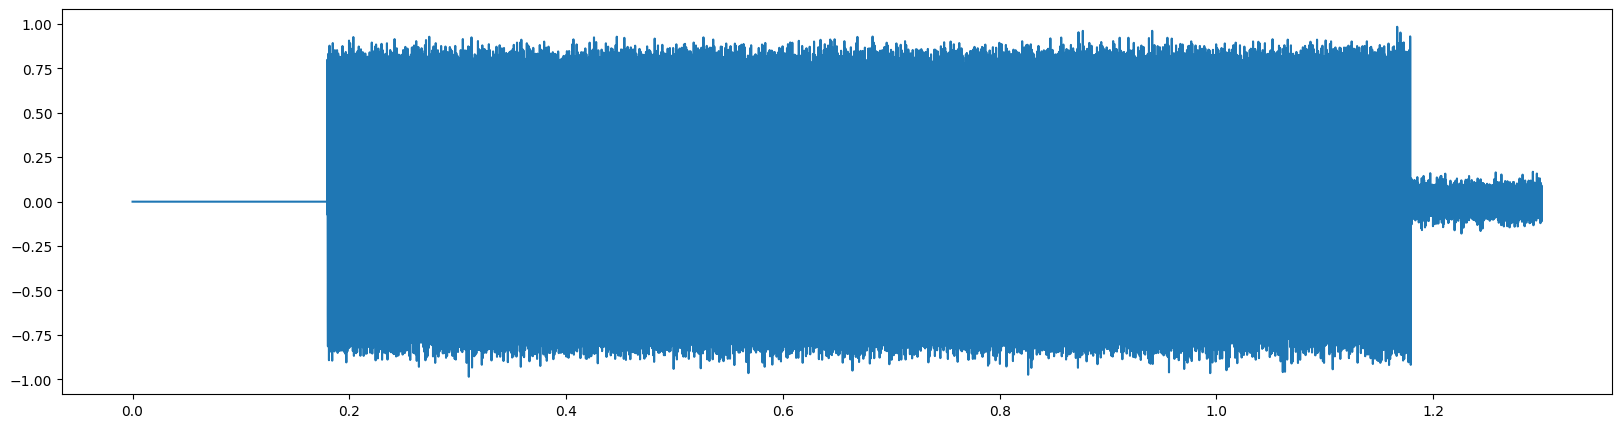

In [ ]:
# Question 1.2 - modify by adding code at the marked point below
tmax = 1
fs = 44100
f = 1000
t = np.arange(0, tmax, 1/fs)
x = np.sin(2*π*f*t)

# modify the signal `x` here!
# (add some silence after the pure tone, enough so that the recording will capture the entire tone)
x = np.concatenate((x, np.zeros(int(0.3 * fs))))
t = np.arange(0, tmax + 0.3, 1/fs)
y = simulated_channel(x)
plt.plot(t, y)
plt.show()


<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 1.3. - Simulated Channel.</span> Comment on the similarities and differences between the received tone and the transmitted tone (other than delay). (_e.g._, check length, amplitude, how consistent they are, any disturbances…)

_WHAT WE EXPECT:_ A short answer with a few sentences explaining your observations.

> Both tones have the same length (1 seconds). The original transmitted signal has amplitude 0.8 and the received signal has amplitude around 0.875 (higher amplitude). Both signals are consistent with almost the same frequencies but the received signal has more disturbances and is more nnoisy.

### Playback and recording

Now, let us move forward to the physical speaker-microphone system! To **play** a signal, we can pass the signal vector and its sampling rate to `sd.play()`. When running the next signal, you should hear a sound.

In [ ]:
tmax = 1
fs = 44100
f = 1000
t = np.arange(0, tmax, 1/fs)
x = np.sin(2*π*f*t)

sd.play(x, fs)

<div class="alert alert-warning">If you didn't hear a sound when running the cell above, check your speaker volume, and be sure to troubleshoot this before continuing.</div>

<div class="alert alert-success"><strong>FIX VOLUME - Something you should definitely do now:</strong> Adjust the volume on your speaker until the tone is at a loud, but comfortable, level. A louder volume is helpful as it gives a better recording of the signal. Make sure that you note down this volume and keep it the same for the complete Project 2 (not just 2a). Later in the project (not this week), you will need to set thresholds based on the amplitude of the signal you record and this amplitude depends on the volume.</div>

To **play and record simultaneously**, we can pass it instead to `sd.playrec()`. The `blocking=True` argument tells the function not to return (to "block") until playback and recording are finished. If you are not sure if the signal is recorded correctly, your plot should look somewhat similar to the figures in Question 2.2 below.


<div class="alert alert-warning">For Windows users, if your recorded signal does not look correct, you may need to disable <a href="https://support.microsoft.com/en-gb/topic/disable-audio-enhancements-0ec686c4-8d79-4588-b7e7-9287dd296f72"> Audio Enhancement</a> since otherwise your microphone driver may filter out everything that wasn't a human voice.</div>

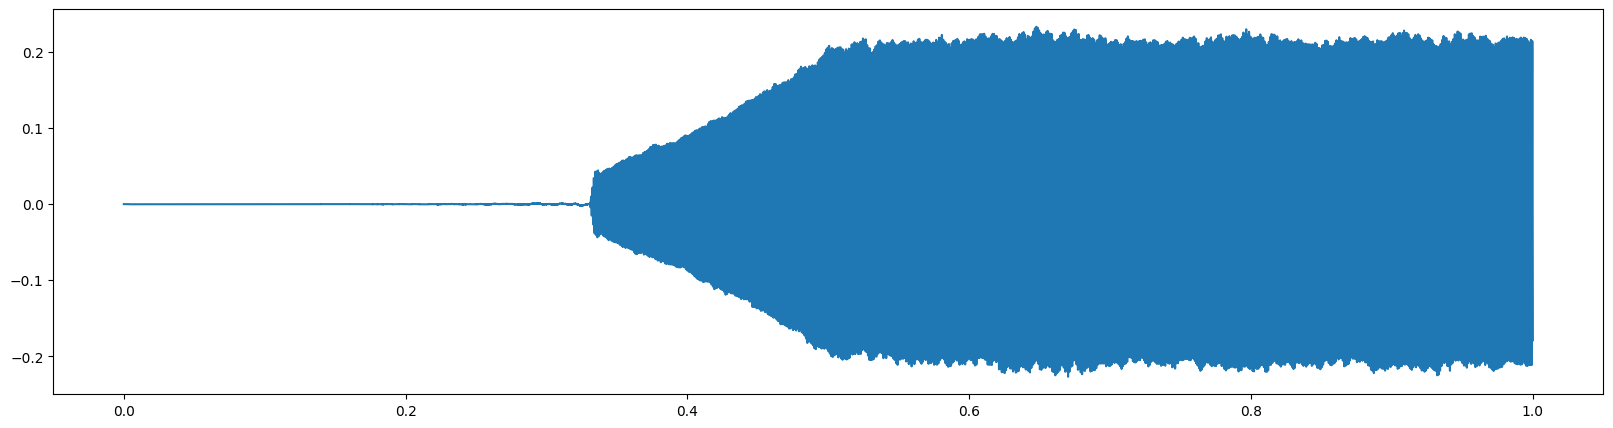

In [ ]:
y = sd.playrec(x, fs, blocking=True)
plt.plot(t, y)
plt.show()

Again, we might take a closer look:

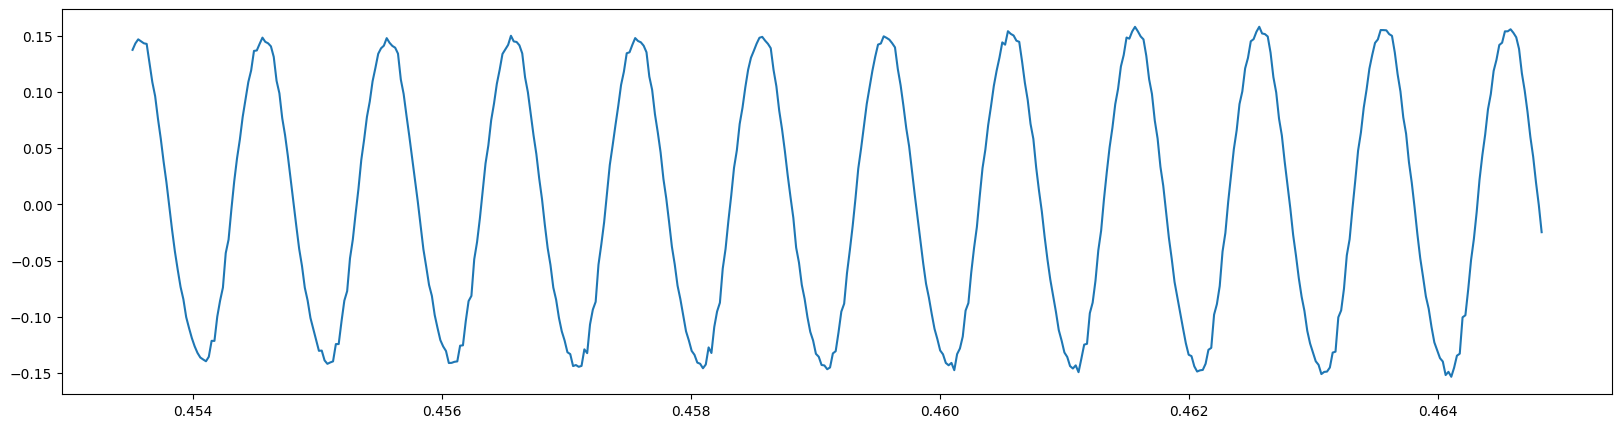

In [ ]:
plt.plot(t[20000:20500], y[20000:20500])
plt.show()

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 1.4. - Physical Channel.</span> Roughly how long after the start of the recording does it appear to start picking up the signal we're playing?

_Note:_ your answer may significantly differ from the simulated channel's delay.

_WHAT WE EXPECT:_ a short 1-sentence answer.

> It appears to start picking up the signal after 0.35 seconds.

As in Question 1.2, we need to add a period of silence after the signal is played, which is a little bit longer than the delay in your system.

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 1.5. - Physical Channel.</span> Modify your code in Question 1.2 by adjusting the length of silence after the original signal, long enough so that the recording captures the entirety of the original signal. With your modification, the plot below should clearly include the entire tone, and possibly a small amount silence after it (but of course not all of the silence you added).

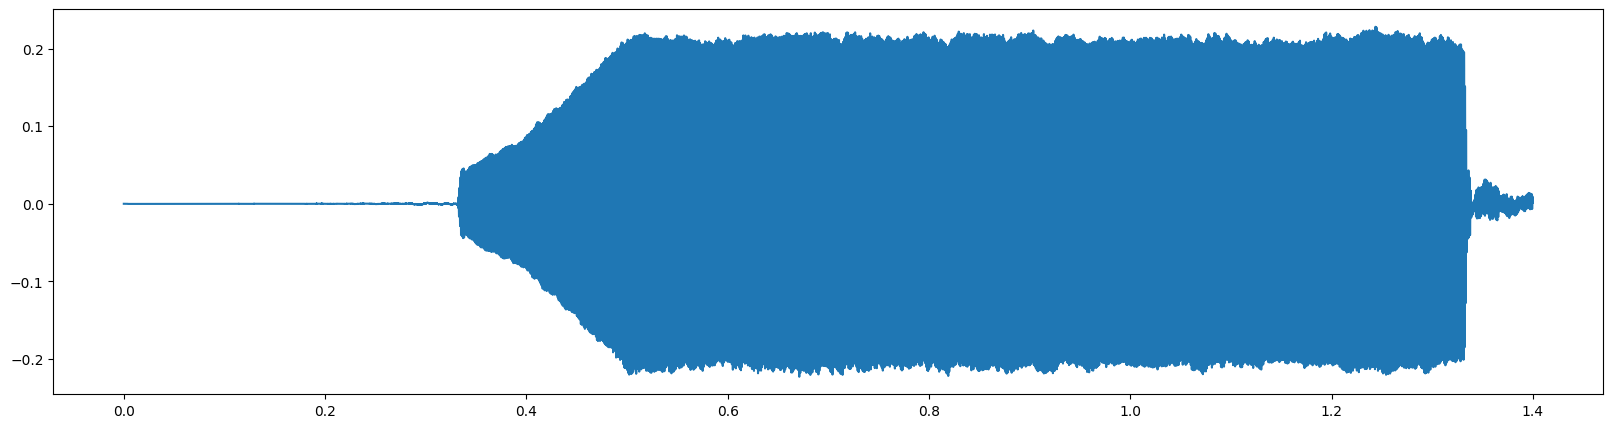

In [ ]:
# Question 1.5 - modify by adding code at the marked point below, or simply copy and paste
# your code in Question 1.2 and adjust the length of silence properly.

tmax = 1
fs = 44100
f = 1000
t = np.arange(0, tmax, 1/fs)
x = np.sin(2*π*f*t)

# modify the signal `x` here!
# (add some silence after the pure tone, enough so that the recording will capture the entire tone)
x = np.concatenate((x, np.zeros(int(0.4 * fs))))
t = np.arange(0, tmax + 0.4, 1/fs)
y = sd.playrec(x, fs, blocking=True, channels=1)
plt.plot(t, y)
plt.show()

# Part 2: Investigate the response of your speaker-microphone system to different frequencies (15 points)

Say that you play, or _transmit_, or _input_, a pure tone of frequency $f$,
$$\tilde x(t) = \sin (2\pi f t).$$
Your microphone will record, or _receive_, or observe an _output_ that looks probably something like a sinusoid of the same frequency, but probably different amplitude $A_\mathrm{out}$,
$$\tilde y(t) = A_\mathrm{out} \sin(2\pi f t + \phi_\mathrm{out}).$$
In practice, this amplitude $A_\mathrm{out}$ tends to vary depending on what frequency $f$ is being used. That is, some frequencies (pitches) will appear "louder" to the receiver than others.

Our goals in this part are:
- to understand how your speaker-microphone system works with different frequencies, and
- to use this information to select a carrier frequency for modulation in Part 3.

<div class="alert alert-info">Engineers sometimes refer to the <em>frequency response</em> of a system, which is the <em>gain</em> $\frac{A_\mathrm{out}}{A_\mathrm{in}}$ as a function of frequency. Because we'll always use an input amplitude of 1, for our purposes we can just focus on the output amplitude. We will not concern ourselves with phase $\phi_\mathrm{out}$ in this project.</div>

We can plot the output amplitude $A_\mathrm{out}$ against frequency $f$. Here is an example:

![image.png](attachment:7f9fd433-ccdd-4523-9453-b798138942f8.png)

<div class="alert alert-success">For a myriad of reasons, every system is different, so you shouldn't expect your frequency response to look like anyone else's, or like the one above.</div>


### Measuring the output amplitude

Although the output amplitude is defined as the maximum value of the sinusoid, when we're measuring the output amplitude, single-sample disturbances can make just taking the maximum value unreliable. It's better to try to use all of the samples to estimate the output amplitude. One such strategy is to take the root-mean-square (rms) value, multiplied by $\sqrt 2$, where $y[n]$ is the output signal and $N$ is the number of samples:

$$A_\mathrm{out} = \sqrt{\frac{1}{N} \sum_{n=0}^{N-1} (y[n])^2} \cdot \sqrt{2}.$$

<div class="alert alert-info"><strong>Theoretical grounding.</strong> The continuous-time equivalent of the above formula would be
    $$A_\mathrm{out} = \sqrt{\frac{1}{t_\mathrm{max}} \int_0^{t_\mathrm{max}} [y(t)]^2\,dt} \cdot \sqrt{2}.$$
If you're curious, you can show that if $y(t) = A_\mathrm{out} \sin(2\pi f t)$ and $t_\mathrm{max}$ is an integer number of periods $t_\mathrm{max} = k/f$, then $A_\mathrm{out}$ will coincide with $A_\mathrm{out}$.</div>

Below we give a function that estimates the output amplitude for a given frequency. It plays a short pure tone of duration `tmax`, and then estimates the $A_\mathrm{out}$ based only on the samples after `tmin` seconds (to avoid the startup delay you observed in Part 1).

If we set `plot=True`, then the function plots the signal, indicates with a line which samples are being used for the computation, and also shows the estimated output amplitude. Most of the time, we will not use `plot=True`. But in the cell below, we'll use the plot to calibrate the other default parameters.

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 2.1. - Simulated Channel</span> Run the cell below and assess whether the samples being used for the output amplitude computation are appropriate. Change the default `tmax` and `tmin` to something sensible for the simulated channel. You should find that the horizontal orange lines roughly match the amplitude of the received waveform.

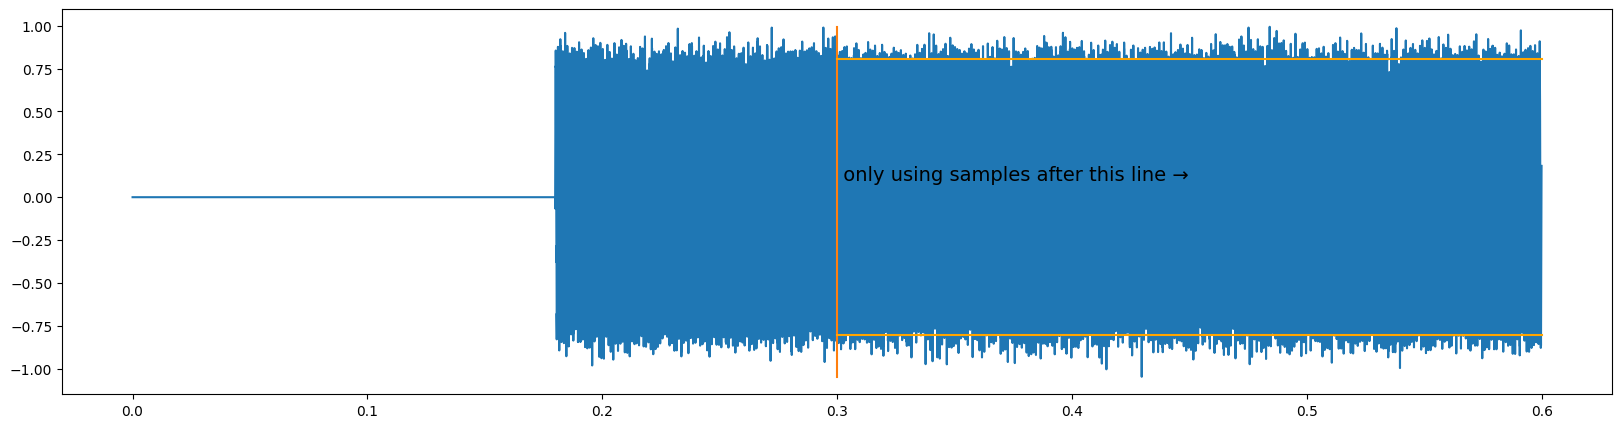

0.8054950406713517

In [ ]:
# Question 2.1. Run this cell and set `tmin` and `tmax` so that it produces a reasonable estimate of the output amplitude.

def estimate_simulated_amplitude(f, fs=44100, tmax=1, tmin=0.3, plot=False, zoom_in=False):
    t = np.arange(0, tmax, 1/fs)
    x = np.sin(2*π*f*t)
    y = simulated_channel(x)
    nmin = int(tmin * fs)
    yrms = np.sqrt(np.mean(y[nmin:] ** 2))
    yamp = yrms * np.sqrt(2)

    if plot:  # used for calibration only
        if not zoom_in:
            plt.plot(t, y)
            plt.plot([tmin, tmin], [np.min(y), np.max(y)])
            plt.text(tmin, 0.1, " only using samples after this line →", size=14)
            plt.plot([tmin, tmax], [[yamp, -yamp], [yamp, -yamp]], color='orange')
            plt.show()
        else:
            tstop = 0.1
            nstop = nmin + int(tstop*fs)
            plt.plot(t[nmin:nstop], y[nmin:nstop])
            plt.plot([tmin, tmin], [np.min(y), np.max(y)])
            plt.plot([tmin, tmin+tstop], [[yamp, -yamp], [yamp, -yamp]], color='orange')
            plt.show()

    return yamp

# Set your tmax, tmin here! #original tmax=1 and tmin=0
tmax = 0.6
tmin = 0.3 #does my graph look reasonable

estimate_simulated_amplitude(f=1000, tmax=tmax, tmin=tmin, plot=True)

We can zoom in the above plot to check the estimated amplitude:

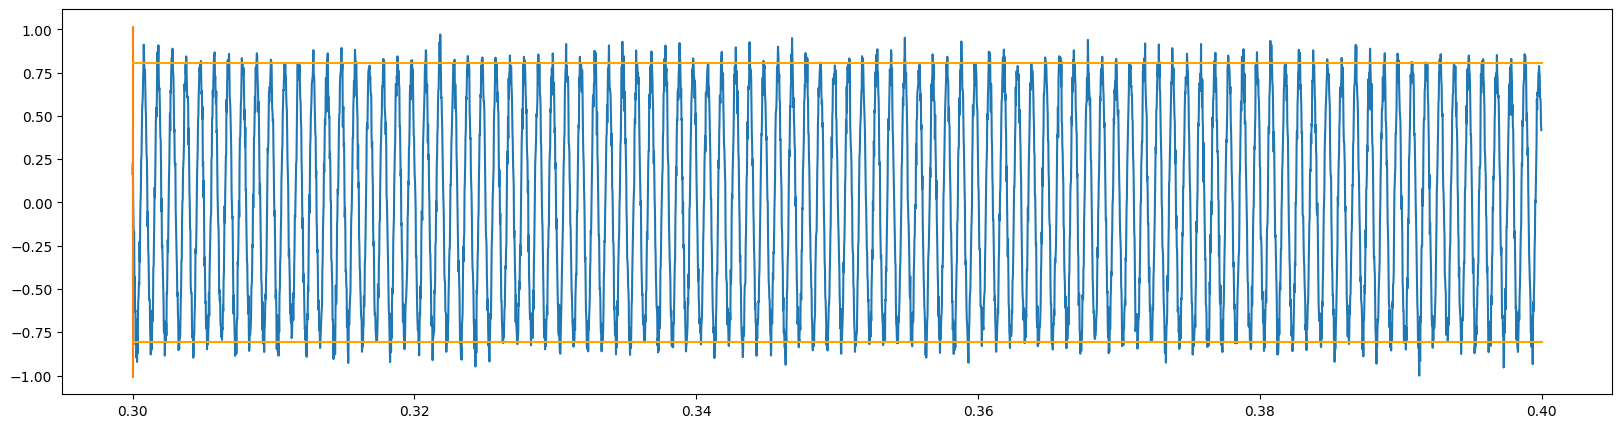

0.8035650543344321

In [ ]:
estimate_simulated_amplitude(f=1000, tmax=tmax, tmin=tmin, plot=True, zoom_in=True)

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 2.2. - Physical Channel.</span> Now, let us move on to the physical system. Run the cell below and assess whether the samples being used for the output amplitude computation are appropriate. Change the default `tmax` and `tmin` to something sensible for your system. You should find that the horizontal orange lines roughly match the amplitude of the waveform.

Here are some examples of when the plot looks right, because `tmin` is set appropriately:

![image.png](attachment:334da8ae-cf14-4b38-94ae-202df8ac99f7.png)![image.png](attachment:8982e59b-ba58-4f54-880e-67ec8e08beec.png)

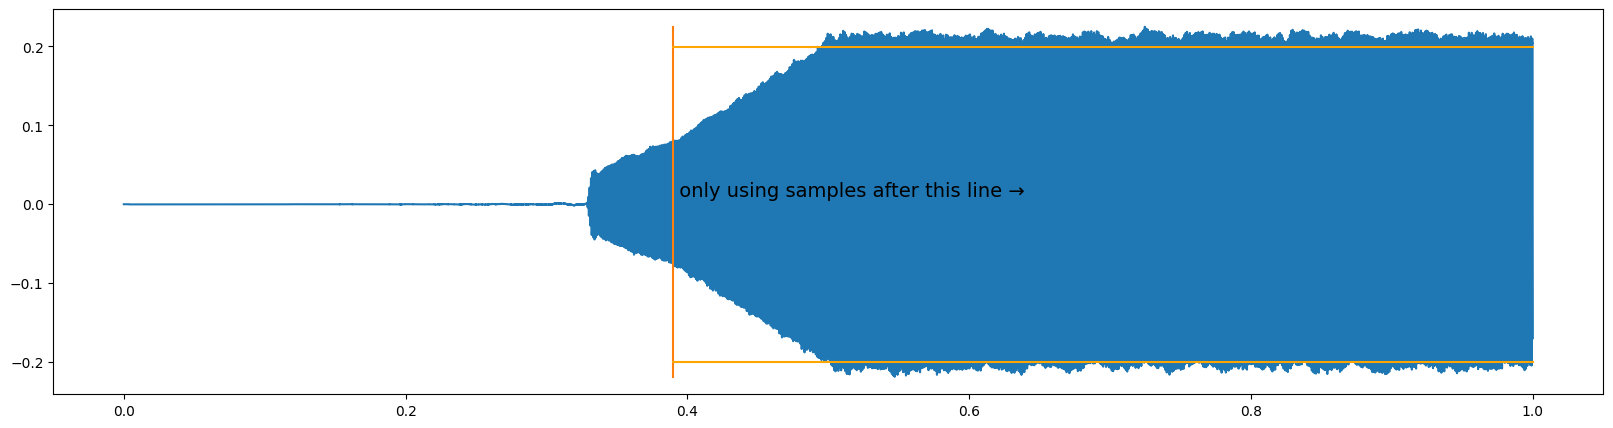

0.199700787825129

In [ ]:
# Question 2.2. Run this cell and set `tmin` and `tmax` so that it produces a reasonable estimate of the output amplitude.

def estimate_output_amplitude(f, fs=44100, tmax=1, tmin=0.5, plot=False, zoom_in=False):
    t = np.arange(0, tmax, 1/fs)
    x = np.sin(2*π*f*t)
    y = sd.playrec(x, fs, blocking=True)
    nmin = int(tmin * fs)
    yrms = np.sqrt(np.mean(y[nmin:] ** 2))
    yamp = yrms * np.sqrt(2)

    if plot:  # used for calibration only
        if not zoom_in:
            plt.plot(t, y)
            plt.plot([tmin, tmin], [np.min(y), np.max(y)])
            plt.text(tmin, 0.01, " only using samples after this line →", size=14)
            plt.plot([tmin, tmax], [[yamp, -yamp], [yamp, -yamp]], color='orange')
            plt.show()
        else:
            tstop = 0.1
            nstop = nmin + int(tstop*fs)
            plt.plot(t[nmin:nstop], y[nmin:nstop])
            plt.plot([tmin, tmin], [np.min(y), np.max(y)])
            plt.plot([tmin, tmin+tstop], [[yamp, -yamp], [yamp, -yamp]], color='orange')
            plt.show()

    return yamp


# Set your tmax, tmin here!
tmax = 1
tmin = 0.39

estimate_output_amplitude(1000, tmax=tmax, tmin=tmin, plot=True)

Let us take a closer look:

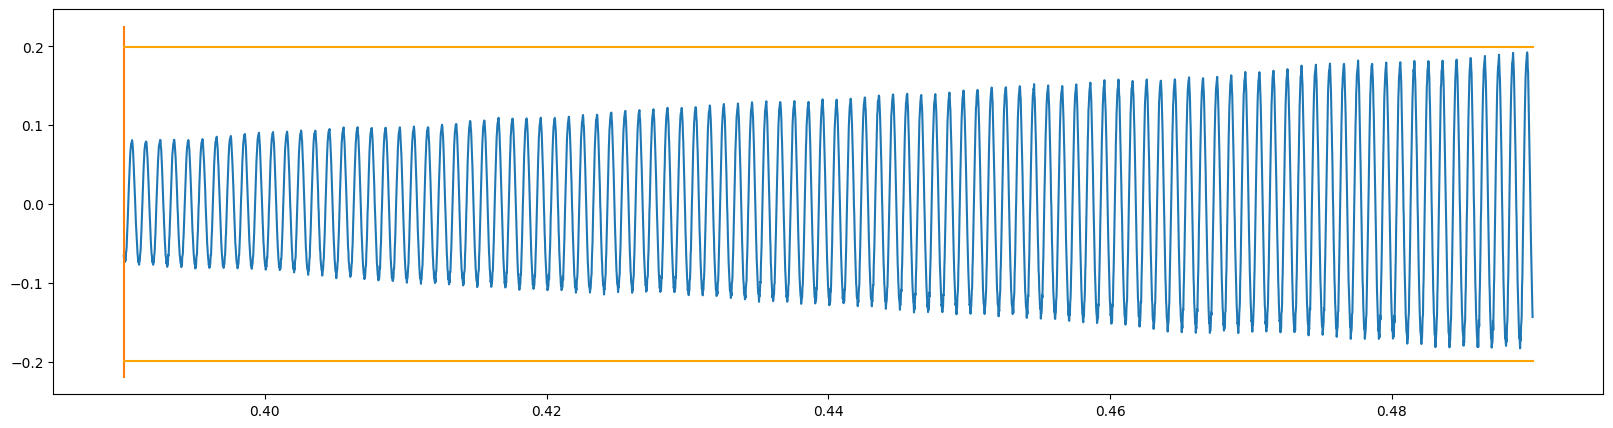

0.1987503014004446

In [ ]:
estimate_output_amplitude(1000, tmax=tmax, tmin=tmin, plot=True, zoom_in=True)

### Trying out different frequencies

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 2.3. - Simulated Channel.</span> By running `estimate_simulated_amplitude()` on many different frequencies, generate a plot of estimated output amplitude versus frequency.

We've provided a range of frequencies between 200 Hz and 5000 Hz in the cell. You're welcome to extend this range further (up to 50 Hz–20 kHz) and/or include more values if you like, but please include at least the 200–5000 Hz range. It's sensible to space these on a logarithmic scale, as we've done. (It's not necessary to include the exact values, or number of values, that we provided.) You can use `plt.semilogx()` to put the horizontal axis on a logarithmic scale.

_Hint:_ The amplitude of the simulated channel should range from 0.6 to 1.

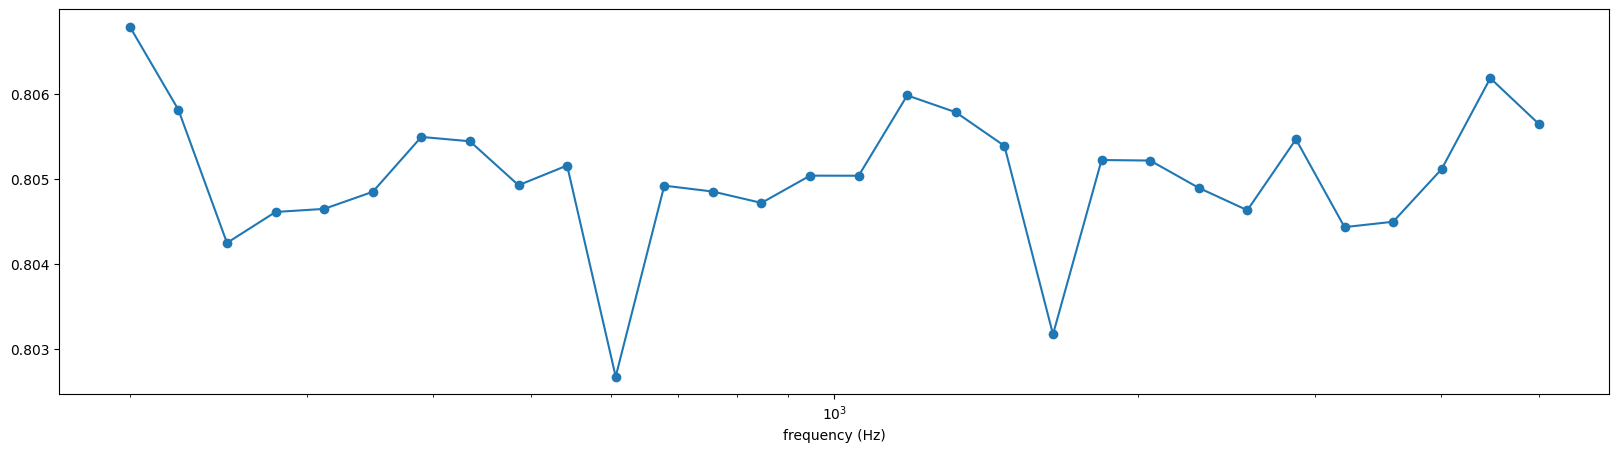

Amplitude at   200.00 hz:  0.807
Amplitude at   223.48 hz:  0.806
Amplitude at   249.71 hz:  0.804
Amplitude at   279.03 hz:  0.805
Amplitude at   311.78 hz:  0.805
Amplitude at   348.38 hz:  0.805
Amplitude at   389.28 hz:  0.805
Amplitude at   434.97 hz:  0.805
Amplitude at   486.04 hz:  0.805
Amplitude at   543.09 hz:  0.805
Amplitude at   606.85 hz:  0.803
Amplitude at   678.08 hz:  0.805
Amplitude at   757.68 hz:  0.805
Amplitude at   846.63 hz:  0.805
Amplitude at   946.01 hz:  0.805
Amplitude at  1057.07 hz:  0.805
Amplitude at  1181.16 hz:  0.806
Amplitude at  1319.81 hz:  0.806
Amplitude at  1474.74 hz:  0.805
Amplitude at  1647.87 hz:  0.803
Amplitude at  1841.31 hz:  0.805
Amplitude at  2057.46 hz:  0.805
Amplitude at  2298.99 hz:  0.805
Amplitude at  2568.86 hz:  0.805
Amplitude at  2870.42 hz:  0.805
Amplitude at  3207.38 hz:  0.804
Amplitude at  3583.90 hz:  0.804
Amplitude at  4004.61 hz:  0.805
Amplitude at  4474.71 hz:  0.806
Amplitude at  5000.00 hz:  0.806


In [ ]:
frequencies = np.logspace(np.log10(200), np.log10(5000), 30)

amplitudes = []  # replace with code generating estimated amplitudes for frequencies in `frequencies`
for f in frequencies:
    amp = estimate_simulated_amplitude(f, fs=44100, tmax=0.6, tmin=0.3, plot=False, zoom_in=False)
    amplitudes.append(amp)

# use `plt.semilogx()` to put the x axis on a logarithmic scale.
plt.semilogx(frequencies, amplitudes, marker='o')
plt.xlabel('frequency (Hz)')
plt.show()

# print out the amplitudes
for response in zip(frequencies, amplitudes):
    print(f'Amplitude at{response[0]: 9.2f} hz: {response[1]: .3f}')

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 2.4. - Physical Channel.</span> Now, let us move forward to the physical channel. This time, run `estimate_output_amplitude()` on many different frequencies and generate a plot of estimated output amplitude versus frequency.

We've provided a range of frequencies between 200 Hz and 5000 Hz in the cell. You're welcome to extend this range further (up to 50 Hz–20 kHz) and/or include more values if you like, but please include at least the 200–5000 Hz range. It's sensible to space these on a logarithmic scale, as we've done. (It's not necessary to include the exact values, or number of values, that we provided.) You can use `plt.semilogx()` to put the horizontal axis on a logarithmic scale.

_Hint:_ The amplitude of the physical channel and how the curve looks may be very different from the simulated one that you obtained in Question 2.3. It may depend on several factors, e.g., the volume of your speaker, the noise level of the environment, etc.

<div class="alert alert-danger"><strong>Warning:</strong> High frequencies (above about 4000 Hz) can be irritating to listen to. Warn the people around you before you do this, don't do this late at night or in a social environment that is expected to be quiet, and have your finger on your computer's mute button, just in case.</div>

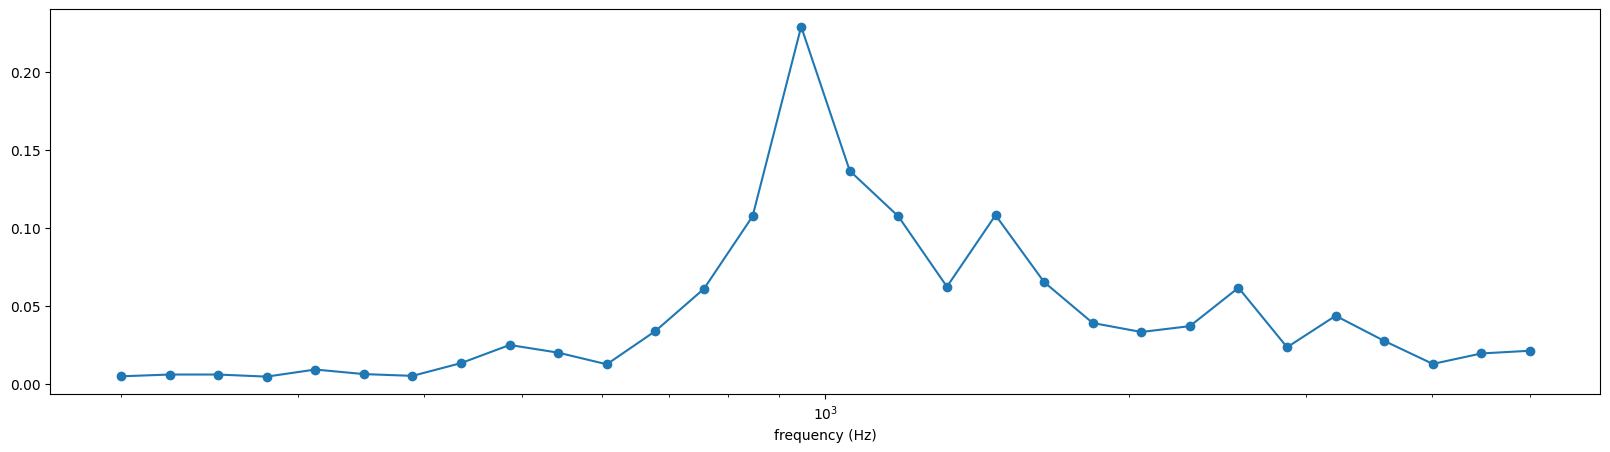

Amplitude at   200.00 hz:  0.005
Amplitude at   223.48 hz:  0.006
Amplitude at   249.71 hz:  0.006
Amplitude at   279.03 hz:  0.005
Amplitude at   311.78 hz:  0.009
Amplitude at   348.38 hz:  0.006
Amplitude at   389.28 hz:  0.005
Amplitude at   434.97 hz:  0.013
Amplitude at   486.04 hz:  0.025
Amplitude at   543.09 hz:  0.020
Amplitude at   606.85 hz:  0.013
Amplitude at   678.08 hz:  0.034
Amplitude at   757.68 hz:  0.061
Amplitude at   846.63 hz:  0.108
Amplitude at   946.01 hz:  0.229
Amplitude at  1057.07 hz:  0.137
Amplitude at  1181.16 hz:  0.107
Amplitude at  1319.81 hz:  0.062
Amplitude at  1474.74 hz:  0.108
Amplitude at  1647.87 hz:  0.065
Amplitude at  1841.31 hz:  0.039
Amplitude at  2057.46 hz:  0.033
Amplitude at  2298.99 hz:  0.037
Amplitude at  2568.86 hz:  0.062
Amplitude at  2870.42 hz:  0.024
Amplitude at  3207.38 hz:  0.044
Amplitude at  3583.90 hz:  0.028
Amplitude at  4004.61 hz:  0.013
Amplitude at  4474.71 hz:  0.020
Amplitude at  5000.00 hz:  0.021


In [ ]:
frequencies = np.logspace(np.log10(200), np.log10(5000), 30) #run this again at home with quiet place
amplitudes = []  # replace with code generating estimated amplitudes for frequencies in `frequencies`
for f in frequencies:
    amp = estimate_output_amplitude(f, fs=44100, tmax=1, tmin=0.39, plot=False, zoom_in=False)
    amplitudes.append(amp)

# use `plt.semilogx()` to put the x axis on a logarithmic scale.
plt.semilogx(frequencies, amplitudes, marker='o')
plt.xlabel('frequency (Hz)')
plt.show()

# print out the amplitudes (for question 2.5)
for response in zip(frequencies, amplitudes):
    print(f'Amplitude at{response[0]: 9.2f} hz: {response[1]: .3f}')

### Selecting a carrier frequency

The _carrier frequency_ is the frequency of the sinusoid on which your data transmission will be based. In the next part, we will use your carrier frequency to communicate digital bits. In most contexts, your carrier frequency is dictated to you by design specifications. However, because we're dealing with sound, we have some freedom to choose a carrier frequency that suits us.

<div class="alert alert-info">When people say that Wi-Fi runs at 2.4 GHz, or that (some versions of) 5G runs at around 700 MHz, or that a radio station is on 90.1 MHz, they're referring to the <em>carrier frequency</em> of the signal used to transmit the message. In most contexts, the carrier frequency that is used is dictated by FCC spectrum regulations. For example, telcos like AT&amp;T and Verizon must purchase (from the government) the right to use particular frequency bands, and the carrier frequencies they use must then be contained within that band. Technologies like Wi-Fi and Bluetooth use carrier frequencies in a band that was set aside by the FCC for unregulated use.</div>

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 2.5. - Physical Channel.</span> Using your findings from Question 2.4, list some frequencies that would make appropriate carrier frequencies. (They don't need to be exact.) Things you might consider:
- The observed output amplitude at that frequency—it helps if it appears louder to the microphone.
- The frequency itself—higher carrier frequencies will provide more scope to expand the bandwidth as we push up the data rate, so if you can choose a frequency higher than 2 kHz, that can be helpful.

_WHAT WE EXPECT:_ a short paragraph.


> Some appropriate carrier frequencies include 1057.07 hz, 846.63 hz, and 946.01 hz because they correspond to the highest amplitudes in the signal above.

# Part 3: Implement an on-off keying (OOK) system (25 points)

_On-off keying_ (OOK) is a digital modulation scheme that uses the presence or absence of a sinusoid at the carrier frequency to communicate 1s and 0s. The transmission is divided into symbols, each lasting $T = 1/r$ seconds, where $r$ is the data rate (in bits per second). For each symbol, the transmitter outputs a sinusoid at the carrier frequency $f_c$ to communicate a 1, or nothing (all zeros) to communicate a 0.

![image.png](attachment:bbcece95-53a1-4dd5-ba71-d8a59eea263a.png)

### Generate the modulated signal

One approach to generating the modulated signal is as follows:

1. Generate a **baseband signal** based on the message. The baseband signal should cover 1 bit every $T = 1/r$ seconds, where $r$ is the bit rate (number of bits per second).

   ![image.png](attachment:20c6c5b0-59dc-48f2-bf5c-b5b71b154494.png)
   
   Remember that your baseband signal needs to correspond to your time vector $t[n]$, which still contains sampling times spaced by $T_s = 1/f_s$, so $t[0] = 0, t[1] = T_s, t[2] = 2T_s, \dots$. This means that if your symbol duration is $T = 1/r$, the baseband signal will be defined as
   $$\mathrm{baseband}[n] = \begin{cases}
       1, &\text{if } \mathrm{message}[\lfloor nT_s/T \rfloor] = 1, \\
       0, &\text{if } \mathrm{message}[\lfloor nT_s/T \rfloor] = 0
   \end{cases}$$
   where `message` is the vector of message bits.

2. Generate the **modulated signal** by multiplying the baseband signal by a pure tone at the carrier frequency, $$x[n] = \mathrm{baseband}[n] \cdot \sin(2\pi f_c t[n]).$$ This should yield the OOK signal above.

   Note that in NumPy, element-wise multiplication is done using the standard multiplication operator `*`.   

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 3.1.</span> We've provided code that generates a random 24-bit message below. Follow the steps above to generate the modulated signal using a (snail-paced) rate of 4 bits per second. Plot the modulated signal against time (in seconds). We will append a `1` at the beginning of the signal so that we know when it starts.

message: [1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1]


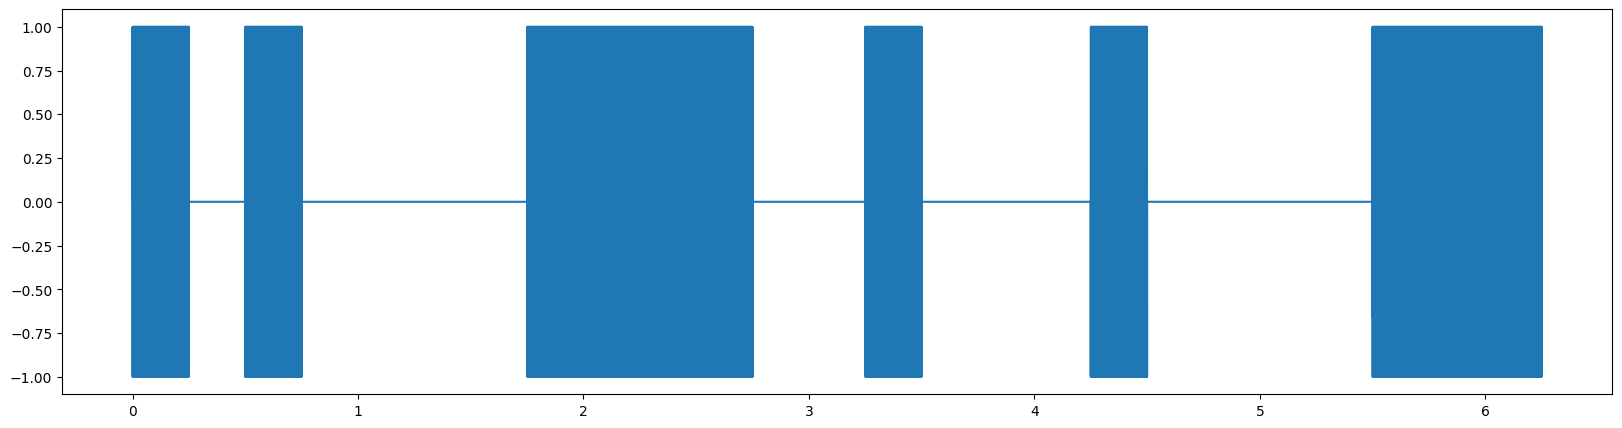

In [ ]:
# Question 3.1. Generate the modulated signal.

rng = default_rng(seed=2024)
message = rng.integers(0, 2, 24)
message = np.insert(message, 0, 1)  # always start the message with a 1 (we'll see why soon)
print("message:", message)
rate = 4    # bits per second, will increase later
fc = 1057.07   # fill in your chosen carrier frequency

# generate `x` here, then plot it against time
fs = 44100
tmax = len(message)/rate
t = np.arange(0, tmax, 1/fs)
ts = 1/fs
baseband = np.zeros(int(len(message)*fs/rate))
for i in range(len(t)):
    index = int(np.floor(i*rate/fs))
    if message[index] == 1:
        baseband[i] = 1
    else:
        baseband[i] = 0
x = baseband * np.sin(2*np.pi * fc * t)

plt.plot(t, x)
plt.show()

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 3.2.</span> Play the modulated signal (code below) and describe what it sounds like.

_WHAT WE EXPECT:_ a short answer with 1-2 sentences.

In [ ]:
sd.play(x, fs)

> It sounds like a very clear, multiple high C notes with no noise repeated many times with some pauses in between.

### Demodulate the received signal

Let us call the received signal $y[n]$. Our next job is: Given $y[n]$, how do we determine what the transmitted message was?

Here's a simple demodulation strategy: Divide the received signal into the samples corresponding to each symbol. Compute the "energy" contained in each symbol, and decode it as 1 if it's above a certain threshold. By "energy", we just mean the sum of squares of the samples within a symbol. So, if a symbol starts at sample $n_\textrm{start}$ and ends at sample $n_\textrm{end}$, then the "energy" contained within that symbol is given by
$$\mathrm{energy} = \sum_{n = n_\textrm{start}}^{n_\textrm{end}} (y[n])^2,$$
where $y[n]$ is the received signal. Some quick intuition is as follows: The square makes everything positive, so we're just adding together positive versions of the signal. Since the symbol for "1" spends more time further away from zero, it will have more energy. (You could also achieve the same thing using the absolute value in place of the square; we don't mind if you do that instead.)

(There are more robust demodulation strategies than this one, but they're beyond the scope of this class.)

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 3.3. (a) - Simulated Channel.</span> As usual, we begin by passing the modulated signal you generated above to the simulated channel. But first, remember to add the silence as we did in Question 1.2 because the channel has an initial random delay.

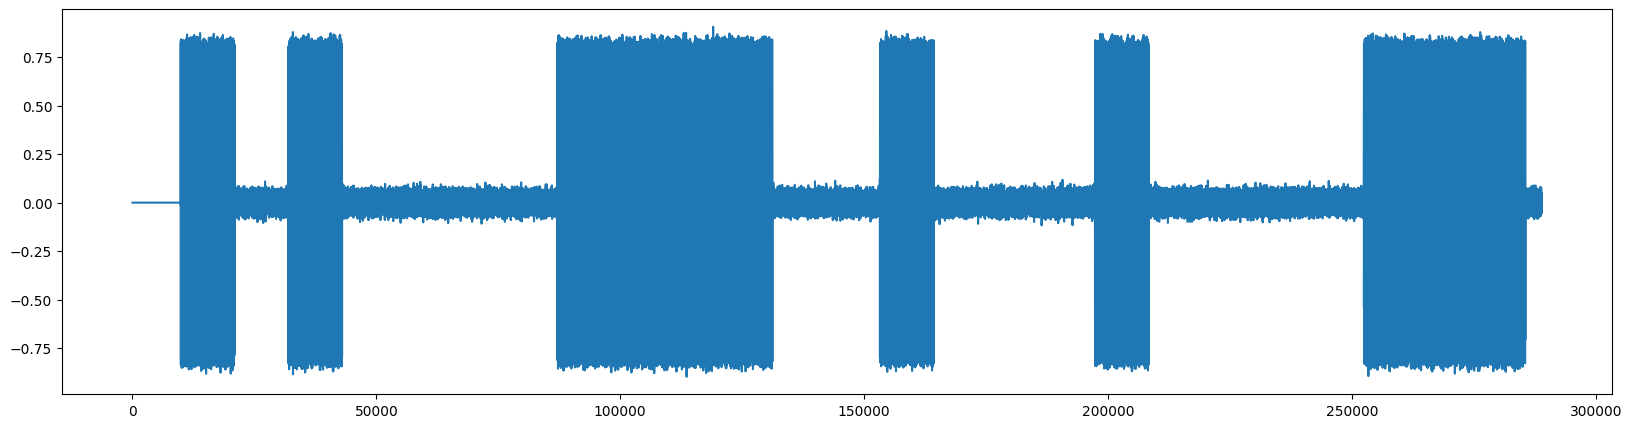

In [ ]:
# Question 3.3. (a)
# BEFORE YOU RUN: add silence to the end of `x`, just like you did in Question 1.2.
x = np.sin(2*π*fc*t) * baseband
x = np.concatenate((x, np.zeros(int(0.3 * fs))))
y_sim = simulated_channel(x)
plt.plot(y_sim)
plt.show()

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 3.3. (b) - Physical Channel.</span> Now, play, record, and plot the modulated signal. Again, do not forget to add the silence to your signal (the length of the silence may be different from that of the simulated channel - this length of silence will correspond to the silence you used in Question 1.5).

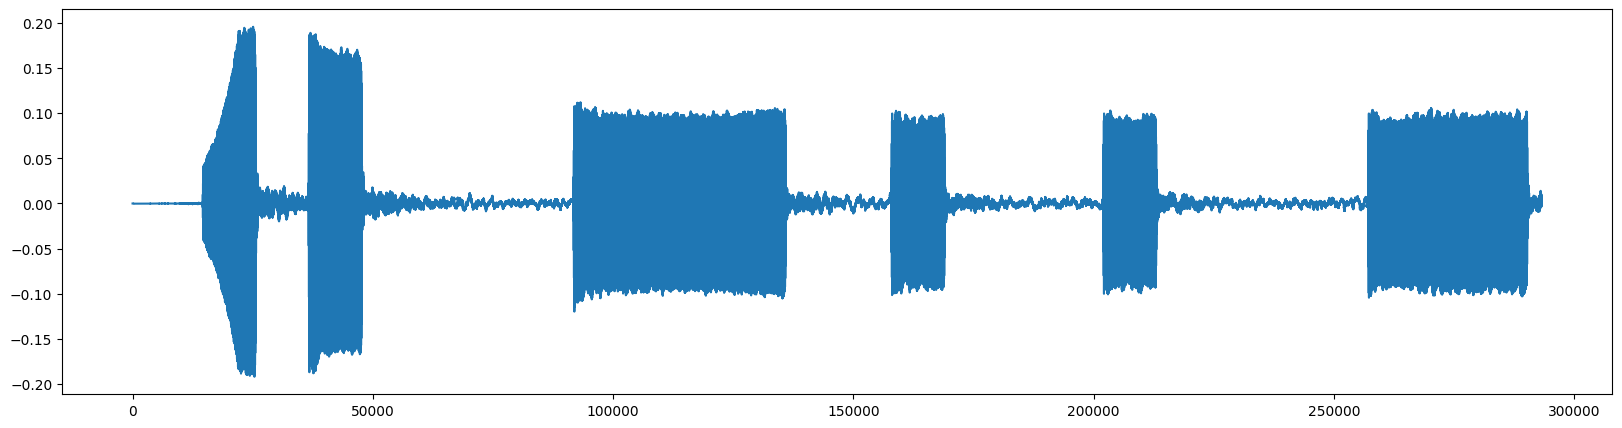

In [ ]:
# Question 3.3. (b)
# BEFORE YOU RUN: add silence to the end of `x`, just like you did in Question 1.2.
x = np.sin(2*π*fc*t) * baseband
x = np.concatenate((x, np.zeros(int(0.4 * fs))))
y_rec = sd.playrec(x, fs, blocking=True)
plt.plot(y_rec)
plt.show()

You'll notice one more practical complication: The information-carrying part of the signal doesn't start at the beginning of the received (recorded) signal. We'll need to detect when the signal "starts".

"Lining up" the symbols is a process known in communications engineering as _synchronization_, and there are many ways to do this. We'll use a very simple (and not very robust) strategy: If we agree that the first bit is always a 1 (_i.e._, does not carry any real information from the message), then we can just detect when the absolute value of the signal crosses some threshold for the first time, and call that the "first sample". Precisely what the threshold is isn't too important—just pick a number that reliably discriminates between "noise at the beginning" and "the actual signal". You might (but are not required to) choose to determine this threshold dynamically, based on the maximum value of the received signal.

_NumPy note._ To find the first sample crossing the threshold, [the `np.nonzero()` function](https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html) with a boolean array might be useful—try `np.nonzero(np.abs(y) > threshold)[0][0]` (where `threshold` is your threshold).

![image.png](attachment:0fefc879-05c4-46dc-a5e9-23b2e903534a.png)

Then, having established where the start is, we can discard the unwanted samples, and count off the samples that correspond to each symbol. Note that, because of rounding, symbols may sometimes have slightly different numbers of samples. One way to group samples into symbols is to say that a sample $n$ belongs to symbol $k$ if $\lfloor nT_s/T \rfloor = k$.

![image.png](attachment:b5ffc6b4-a6be-40c6-a527-31ced5f9d161.png)

Having partitioned the samples into those corresponding to each symbol, we compute the energy corresponding to each symbol (as discussed above), and decode as 1 those symbols whose energy is above some threshold. (For now, we're not too particular about how you choose this threshold, so long as it cleanly discriminates between 0s and 1s.)


<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 3.4. (a) - Simulated Channel.</span> Write code that takes the received signal `y_sim` and recovers the original message.

We recommend using the process we outlined above, but you're not obliged to if you have other ideas. It's fine to use knowledge of parameters like $f_c$, $f_s$, $T_s$, $T$ and $r$—you can assume that the receiver and transmitter agreed on these conventions in advance. You should not, of course, use `x` or `message`. We've provided code to compute the bit error rate (the number of decoding errors, divided by the length of the message).

In [ ]:
# Question 3.4. (a)
# Write your code to decode `y_sim` here.

rate = 4
fs = 44100
num_samples = int(fs/rate)

threshold_1 = 0.001
threshold_2 = 10 #tweaked value to my local machine
start_index = np.nonzero(np.abs(y_sim) > threshold_1)[0][0]
energies = []
count = 0
for i in range(start_index, len(y_sim), num_samples):
    if (count > 24):
        break
    e = np.sum(np.square(y_sim[i:i+num_samples]))
    energies.append(e)
    count += 1
decoded = []
for e in energies:
    if e > threshold_2:
        decoded.append(1)
    else:
        decoded.append(0)
decoded = np.array(decoded)

In [ ]:
# This code can be used to determine your bit error rate. Since you're currently working with low data rates, this should be reliably zero.
# `decoded` should be a np.ndarray object that is the same shape as `message`.

print("Original message: ", message)
print("Decoded message:  ", decoded)
assert (message.size == decoded.size), "decoded length is not equal to the original original length!"
print("Error rate:       ", np.sum(decoded != message) / message.size)

Original message:  [1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1]
Decoded message:   [1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1]
Error rate:        0.0


<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 3.4. (b) - Physical Channel.</span> Write code that takes the physically received signal `y_rec` and recovers the original message. You can reuse your code in the previous question, but you may need to retune the `threshold` and/or `energy` a little.

In [ ]:
# Question 3.4. (b)
# Write your code to decode `y_rec` here. It should be almost the same as your code in Question 3.4. (a).

rate = 4
fs = 44100
num_samples = int(fs/rate)

threshold_1 = 0.025
threshold_2 = 4.0
start_index = np.nonzero(np.abs(y_rec) > threshold_1)[0][0]
energies = []
count = 0
for i in range(start_index, len(y_rec), num_samples):
    if (count > 24):
        break
    e = np.sum(np.square(y_rec[i:i+num_samples]))
    energies.append(e)
    count += 1
decoded = []
for e in energies:
    if e > threshold_2:
        decoded.append(1)
    else:
        decoded.append(0)
decoded = np.array(decoded)

In [ ]:
# This code can be used to determine your bit error rate. Since you're currently working with low data rates, this should be reliably zero.
# `decoded` should be a np.ndarray object that is the same shape as `message`.
print("Original message: ", message)
print("Decoded message:  ", decoded)
assert (message.size == decoded.size), "decoded length is not equal to the original original length!"
print("Error rate:       ", np.sum(decoded != message) / message.size)

Original message:  [1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1]
Decoded message:   [1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1]
Error rate:        0.0


# Part 4: How fast can it go? (25 points)

Now that you have a basic form of OOK going, how fast can it go before it stops being workable on your system? In the following questions, it's fine to just try it a few times and report the data rate that seems to produce errors at approximately some rate. For this week's purposes, you do not need to be rigorous with experiment design. However, you should **adjust the length of your message** so that it's long enough for the results to be meaningful. (It should take, say, at least a few seconds to run.)

<div class="alert alert-success">You might want to have your volume turned up as much as is comfortable, since this generally makes it easier to decode. If you chose a low volume earlier, it may be worth going back, changing the volume to a higher value and starting again from there.</div>

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 4.1. - Physical Channel.</span> Combine your code from Part 3 into a single cell below, that should generate a random message, use `simulated_channel()` and `sd.playrec()` to obtain the noisy signal, then decode them and report the bit error rate. Then try changing the data rate, and re-running the cell. At around what data rate does the decoding have at least 1 bit error most of the time?

_WHAT WE EXPECT:_ a short answer with 1-2 sentences.

> Bit error rates for each data rate is printed in each of the cells below - each cell corresponds to the code for a different data rate such as 4, 12, etc. At around data rate=100, the decoding has at least 1 bit error rate for the simulated channel most of the time, and at around data rate=40, the decoding has at least 1 bit error rate for the physical channel most of the time.

In [ ]:
# Question 4.1 simulated
rate = 4
fs = 44100
num_samples = int(fs/rate)

threshold_1 = 0.001
threshold_2 = 10 #tweaked value to my local machine
start_index = np.nonzero(np.abs(y_sim) > threshold_1)[0][0]
energies = []
count = 0
for i in range(start_index, len(y_sim), num_samples):
    if (count > 24):
        break
    e = np.sum(np.square(y_sim[i:i+num_samples]))
    energies.append(e)
    count += 1
decoded = []
for e in energies:
    if e > threshold_2:
        decoded.append(1)
    else:
        decoded.append(0)
decoded = np.array(decoded)

print("Original message: ", message)
print("Decoded message:  ", decoded)
assert (message.size == decoded.size), "decoded length is not equal to the original original length!"
print("Error rate:       ", np.sum(decoded != message) / message.size)

Original message:  [1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1]
Decoded message:   [1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1]
Error rate:        0.0


In [ ]:
# Question 4.1 simulated
rate = 12
fs = 44100
message = rng.integers(0, 2, rate*4)
message = np.insert(message, 0, 1)
tmax = int(len(message)/rate)
t = np.arange(0, tmax, 1/fs)
ts = 1/fs
baseband = np.zeros(int(tmax*fs))

for i in range(len(t)):
    index = int(np.floor(i * rate / fs))
    if message[index] == 1:
        baseband[i] = 1
    else:
        baseband[i] = 0

x = np.sin(2*π*fc*t) * baseband
x = np.concatenate((x, np.zeros(int(0.3 * fs))))
y_sim = simulated_channel(x)
num_samples = int(fs/rate)
threshold_1 = 0.009
threshold_2 = 50 #tweaked value to my local machine
start_index = np.nonzero(np.abs(y_sim) > threshold_1)[0][0]
energies = []
count = 0

for i in range(start_index, len(y_sim), num_samples):
    if (count > rate*4):
        break
    e = np.sum(np.square(y_sim[i:i+num_samples]))
    energies.append(e)
    count += 1
decoded = []

for e in energies:
    if e > threshold_2:
        decoded.append(1)
    else:
        decoded.append(0)
decoded = np.array(decoded)

print("Original message: ", message)
print("Decoded message:  ", decoded)
assert (message.size == decoded.size), "decoded length is not equal to the original original length!"
print("Error rate:       ", np.sum(decoded != message) / message.size)

Original message:  [1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0
 1 0 1 0 0 1 1 0 0 1 0 0]
Decoded message:   [1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0
 1 0 1 0 0 1 1 0 0 1 0 0]
Error rate:        0.0


In [ ]:
# Question 4.1 simulated
rate = 50
fs = 44100
message = rng.integers(0, 2, rate*4)
message = np.insert(message, 0, 1)
tmax = int(len(message)/rate)
t = np.arange(0, tmax, 1/fs)
ts = 1/fs
baseband = np.zeros(int(tmax*fs))

for i in range(len(t)):
    index = int(np.floor(i * rate / fs))
    if message[index] == 1:
        baseband[i] = 1
    else:
        baseband[i] = 0

x = np.sin(2*π*fc*t) * baseband
x = np.concatenate((x, np.zeros(int(0.3 * fs))))
y_sim = simulated_channel(x)
num_samples = int(fs/rate)
threshold_1 = 0.009
threshold_2 = 50 #tweaked value to my local machine
start_index = np.nonzero(np.abs(y_sim) > threshold_1)[0][0]
energies = []
count = 0

for i in range(start_index, len(y_sim), num_samples):
    if (count > rate*4):
        break
    e = np.sum(np.square(y_sim[i:i+num_samples]))
    energies.append(e)
    count += 1
decoded = []

for e in energies:
    if e > threshold_2:
        decoded.append(1)
    else:
        decoded.append(0)
decoded = np.array(decoded)

print("Original message: ", message)
print("Decoded message:  ", decoded)
assert (message.size == decoded.size), "decoded length is not equal to the original original length!"
print("Error rate:       ", np.sum(decoded != message) / message.size)

Original message:  [1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0
 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
Decoded message:   [1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0
 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
Error rate:        0.0


In [ ]:
# Question 4.1 simulated
rate = 100
fs = 44100
message = rng.integers(0, 2, rate*4)
message = np.insert(message, 0, 1)
tmax = int(len(message)/rate)
t = np.arange(0, tmax, 1/fs)
ts = 1/fs
baseband = np.zeros(int(tmax*fs))
for i in range(len(t)):
    index = int(np.floor(i * rate / fs))
    if message[index] == 1:
        baseband[i] = 1
    else:
        baseband[i] = 0

x = np.sin(2*π*fc*t) * baseband
x = np.concatenate((x, np.zeros(int(0.3 * fs))))
y_sim = simulated_channel(x)
num_samples = int(fs/rate)
threshold_1 = 0.009
threshold_2 = 50 #tweaked value to my local machine
start_index = np.nonzero(np.abs(y_sim) > threshold_1)[0][0]
energies = []
count = 0

for i in range(start_index, len(y_sim), num_samples):
    if (count > rate*4):
        break
    e = np.sum(np.square(y_sim[i:i+num_samples]))
    energies.append(e)
    count += 1
decoded = []

for e in energies:
    if e > threshold_2:
        decoded.append(1)
    else:
        decoded.append(0)
decoded = np.array(decoded)

print("Original message: ", message)
print("Decoded message:  ", decoded)
assert (message.size == decoded.size), "decoded length is not equal to the original original length!"
print("Error rate:       ", np.sum(decoded != message) / message.size)

Original message:  [1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0
 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1
 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0
 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 1 1
 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1
 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 0 1
 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1
 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1
 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1]
Decoded message:   [1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 

In [ ]:
# Question 4.1 simulated
rate = 109
fs = 44100
message = rng.integers(0, 2, rate*4)
message = np.insert(message, 0, 1)
tmax = int(len(message)/rate)
t = np.arange(0, tmax, 1/fs)
ts = 1/fs
baseband = np.zeros(int(tmax*fs))

for i in range(len(t)):
    index = int(np.floor(i * rate / fs))
    if message[index] == 1:
        baseband[i] = 1
    else:
        baseband[i] = 0

x = np.sin(2*π*fc*t) * baseband
x = np.concatenate((x, np.zeros(int(0.3 * fs))))
y_sim = simulated_channel(x)
num_samples = int(fs/rate)
threshold_1 = 0.009
threshold_2 = 50 #tweaked value to my local machine
start_index = np.nonzero(np.abs(y_sim) > threshold_1)[0][0]
energies = []
count = 0

for i in range(start_index, len(y_sim), num_samples):
    if (count > rate*4):
        break
    e = np.sum(np.square(y_sim[i:i+num_samples]))
    energies.append(e)
    count += 1
decoded = []

for e in energies:
    if e > threshold_2:
        decoded.append(1)
    else:
        decoded.append(0)
decoded = np.array(decoded)

print("Original message: ", message)
print("Decoded message:  ", decoded)
assert (message.size == decoded.size), "decoded length is not equal to the original original length!"
print("Error rate:       ", np.sum(decoded != message) / message.size)

Original message:  [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1
 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1
 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1
 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1
 0 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0
 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1
 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0
 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1
 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0
 1 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1
 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1]
Decoded message:   [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1


In [ ]:
# Question 4.1 PHYSICAL
rate = 4
fs = 44100
message = rng.integers(0, 2, 24)
message = np.insert(message, 0, 1)
tmax = int(len(message)/rate)
t = np.arange(0, tmax, 1/fs)
ts = 1/fs
baseband = np.zeros(int(tmax*fs))

for i in range(len(t)):
    index = int(np.floor(i * rate / fs))
    if message[index] == 1:
        baseband[i] = 1
    else:
        baseband[i] = 0

x = np.sin(2*π*fc*t) * baseband
x = np.concatenate((x, np.zeros(int(0.4 * fs))))
y_rec = sd.playrec(x, fs, blocking=True)
num_samples = int(fs/rate)
threshold_1 = 0.025
threshold_2 = 4 #tweaked value to my local machine
start_index = np.nonzero(np.abs(y_rec) > threshold_1)[0][0]
energies = []
count = 0

for i in range(start_index, len(y_rec), num_samples):
    if (count > 24):
        break
    e = np.sum(np.square(y_rec[i:i+num_samples]))
    energies.append(e)
    count += 1
decoded = []

for e in energies:
    if e > threshold_2:
        decoded.append(1)
    else:
        decoded.append(0)
decoded = np.array(decoded)

print("Original message: ", message)
print("Decoded message:  ", decoded)
assert (message.size == decoded.size), "decoded length is not equal to the original original length!"
print("Error rate:       ", np.sum(decoded != message) / message.size)


Original message:  [1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0]
Decoded message:   [1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0]
Error rate:        0.0


In [ ]:
# Question 4.1 PHYSICAL
rate = 12
fs = 44100
message = rng.integers(0, 2, rate*4)
message = np.insert(message, 0, 1)
tmax = int(len(message)/rate)
t = np.arange(0, tmax, 1/fs)
ts = 1/fs
baseband = np.zeros(int(tmax*fs))

for i in range(len(t)):
    index = int(np.floor(i * rate / fs))
    if message[index] == 1:
        baseband[i] = 1
    else:
        baseband[i] = 0

x = np.sin(2*π*fc*t) * baseband
x = np.concatenate((x, np.zeros(int(0.4 * fs))))
y_rec = sd.playrec(x, fs, blocking=True)

num_samples = int(fs/rate)
threshold_1 = 0.025
threshold_2 = 4 #tweaked value to my local machine
start_index = np.nonzero(np.abs(y_rec) > threshold_1)[0][0]
energies = []
count = 0

for i in range(start_index, len(y_rec), num_samples):
    if (count > rate*4):
        break
    e = np.sum(np.square(y_rec[i:i+num_samples]))
    energies.append(e)
    count += 1
decoded = []

for e in energies:
    if e > threshold_2:
        decoded.append(1)
    else:
        decoded.append(0)
decoded = np.array(decoded)

print("Original message: ", message)
print("Decoded message:  ", decoded)
assert (message.size == decoded.size), "decoded length is not equal to the original original length!"
print("Error rate:       ", np.sum(decoded != message) / message.size)


Original message:  [1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 1 0]
Decoded message:   [1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 1 0]
Error rate:        0.0


In [ ]:
# Question 4.1 PHYSICAL
rate = 40
fs = 44100
message = rng.integers(0, 2, rate*4)
message = np.insert(message, 0, 1)
tmax = int(len(message)/rate)
t = np.arange(0, tmax, 1/fs)
ts = 1/fs
baseband = np.zeros(int(tmax*fs))

for i in range(len(t)):
    index = int(np.floor(i * rate / fs))
    if message[index] == 1:
        baseband[i] = 1
    else:
        baseband[i] = 0

x = np.sin(2*π*fc*t) * baseband
x = np.concatenate((x, np.zeros(int(0.4 * fs))))
y_rec = sd.playrec(x, fs, blocking=True)
num_samples = int(fs/rate)
threshold_1 = 0.025
threshold_2 = 4 #tweaked value to my local machine
start_index = np.nonzero(np.abs(y_rec) > threshold_1)[0][0]
energies = []
count = 0

for i in range(start_index, len(y_rec), num_samples):
    if (count > rate*4):
        break
    e = np.sum(np.square(y_rec[i:i+num_samples]))
    energies.append(e)
    count += 1
decoded = []

for e in energies:
    if e > threshold_2:
        decoded.append(1)
    else:
        decoded.append(0)
decoded = np.array(decoded)

print("Original message: ", message)
print("Decoded message:  ", decoded)
assert (message.size == decoded.size), "decoded length is not equal to the original original length!"
print("Error rate:       ", np.sum(decoded != message) / message.size)


Original message:  [1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0
 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0
 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0
 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0
 1 0 0 1 1 1 0 1 1 1 0 1 0]
Decoded message:   [0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0
 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0
 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0
 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0
 1 0 0 1 1 1 0 1 1 1 0 1 0]
Error rate:        0.012422360248447204


In [ ]:
# Question 4.1 PHYSICAL
rate = 85
fs = 44100
fc = 1057.07
message = rng.integers(0, 2, rate*4)
message = np.insert(message, 0, 1)
tmax = int(len(message)/rate)
t = np.arange(0, tmax, 1/fs)
ts = 1/fs
baseband = np.zeros(int(tmax*fs))

for i in range(len(t)):
    index = int(np.floor(i * rate / fs))
    if message[index] == 1:
        baseband[i] = 1
    else:
        baseband[i] = 0

x = np.sin(2*π*fc*t) * baseband
x = np.concatenate((x, np.zeros(int(0.4 * fs))))
y_rec = sd.playrec(x, fs, blocking=True)
num_samples = int(fs/rate)
threshold_1 = 0.025
threshold_2 = 2 #tweaked value to my local machine
start_index = np.nonzero(np.abs(y_rec) > threshold_1)[0][0]
energies = []
count = 0

for i in range(start_index, len(y_rec), num_samples):
    if (count > rate*4):
        break
    e = np.sum(np.square(y_rec[i:i+num_samples]))
    energies.append(e)
    count += 1
decoded = []

for e in energies:
    if e > threshold_2:
        decoded.append(1)
    else:
        decoded.append(0)
decoded = np.array(decoded)

print("Original message: ", message)
print("Decoded message:  ", decoded)
assert (message.size == decoded.size), "decoded length is not equal to the original original length!"
print("Error rate:       ", np.sum(decoded != message) / message.size)


Original message:  [1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1
 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0
 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0
 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0
 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1
 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0
 1 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0
 1 0 0 1 1 1 1 0]
Decoded message:   [0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1
 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0
 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 4.2. - Physical Channel.</span> If we push the data rate a bit further, at around what data rate does the bit error rate seem to consistently be above 5%?

_WHAT WE EXPECT:_ a short answer with 1-2 sentences.

> At around data rate=109 for the simulated channel, the bit error rate seems to be consistently above 5% (such as getting 8-12% approximately very consistently running this cell over and over again). At around data rate=85 for the physical channel, the bit error rate seems to be consistently above 5% (such as getting 8-19% approximately very consistently running this cell over and over again).

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 4.3. - Physical Channel.</span> Try one or two of the other carrier frequency candidates you listed in Question 2.3, preferably ones that are quite different from the $f_c$ you're using now. How do their performances compare?

_WHAT WE EXPECT:_ a short answer with 1-2 sentences.

> I tried the fc = 757.68 Hz frequency below for the simulated channel at rate=109 and physical at rate=85 - their performances are better than with the fc = 1057.07 Hz frequency. For example, for the simulated channel, for rate=109 at fc = 1057.07, we get 0.0938 as the bit error rate while at fc = 543.09 with the same rate and thresholds we get 0.091533 as the bit error rate and for the physical channel, for rate=85 at fc = 1057.07, we get 0.19648 as the bit error rate while at fc = 543.09 with the same rate and thresholds we get 0.1260997 as the bit error rate.

In [ ]:
# Question 4.3 simulated
fc = 757.68

rate = 109
fs = 44100
message = rng.integers(0, 2, rate*4)
message = np.insert(message, 0, 1)
tmax = int(len(message)/rate)
t = np.arange(0, tmax, 1/fs)
ts = 1/fs
baseband = np.zeros(int(tmax*fs))

for i in range(len(t)):
    index = int(np.floor(i * rate / fs))
    if message[index] == 1:
        baseband[i] = 1
    else:
        baseband[i] = 0

x = np.sin(2*π*fc*t) * baseband
x = np.concatenate((x, np.zeros(int(0.3 * fs))))
y_sim = simulated_channel(x)
num_samples = int(fs/rate)
threshold_1 = 0.009
threshold_2 = 50 #tweaked value to my local machine
start_index = np.nonzero(np.abs(y_sim) > threshold_1)[0][0]
energies = []
count = 0

for i in range(start_index, len(y_sim), num_samples):
    if (count > rate*4):
        break
    e = np.sum(np.square(y_sim[i:i+num_samples]))
    energies.append(e)
    count += 1
decoded = []

for e in energies:
    if e > threshold_2:
        decoded.append(1)
    else:
        decoded.append(0)
decoded = np.array(decoded)

print("Original message: ", message)
print("Decoded message:  ", decoded)
assert (message.size == decoded.size), "decoded length is not equal to the original original length!"
print("Error rate:       ", np.sum(decoded != message) / message.size)

Original message:  [1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1
 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0
 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 1 1
 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 0
 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1
 0 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0
 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0
 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0
 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1]
Decoded message:   [1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1


In [ ]:
# Question 4.3 PHYSICAL
fc = 757.68
rate = 85
fs = 44100
message = rng.integers(0, 2, rate*4)
message = np.insert(message, 0, 1)
tmax = int(len(message)/rate)
t = np.arange(0, tmax, 1/fs)
ts = 1/fs
baseband = np.zeros(int(tmax*fs))

for i in range(len(t)):
    index = int(np.floor(i * rate / fs))
    if message[index] == 1:
        baseband[i] = 1
    else:
        baseband[i] = 0

x = np.sin(2*π*fc*t) * baseband
x = np.concatenate((x, np.zeros(int(0.4 * fs))))
y_rec = sd.playrec(x, fs, blocking=True)
num_samples = int(fs/rate)
threshold_1 = 0.025
threshold_2 = 1.5 #tweaked value to my local machine
start_index = np.nonzero(np.abs(y_rec) > threshold_1)[0][0]
energies = []
count = 0

for i in range(start_index, len(y_rec), num_samples):
    if (count > rate*4):
        break
    e = np.sum(np.square(y_rec[i:i+num_samples]))
    energies.append(e)
    count += 1
decoded = []

for e in energies:
    if e > threshold_2:
        decoded.append(1)
    else:
        decoded.append(0)
decoded = np.array(decoded)

print("Original message: ", message)
print("Decoded message:  ", decoded)
assert (message.size == decoded.size), "decoded length is not equal to the original original length!"
print("Error rate:       ", np.sum(decoded != message) / message.size)

Original message:  [1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0
 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1
 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1
 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1
 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0
 1 0 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0
 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0
 0 0 0 1 0 1 0 1]
Decoded message:   [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0
 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1
 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1
 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0

# Analysis (10 points)

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question A1.</span> We used a very simple synchronization strategy, where we fix the first bit to 1 and detect when the absolute value of the signal exceeds some threshold. What are some limitations of this strategy? Can you think of a more sophisticated synchronization strategy that uses _more_ fixed bits at the start? How would this help, and how would we detect the start in this case?

_Hint:_ Try clapping really loudly just as you start the transmission.

_WHAT WE EXPECT:_ a short paragraph.

> Some limitations include that our strategy relies on the value of the signal exceeding a certain threshold value which means our strategy can be easily swayed/influenced by outside noise at the start of the signal (especially noise that exceeds the threshold value), which can distort the signal. This makes our received signal marking start earlier than it should. A more sophisticated synchronization strategy is to use fixed  patterns of bits at the start of the signal that can be easily detected at the receiver which means we can more reliably detect the beginning of the transmission, even with noises/variations. This will also make the receiver know when the signal starts as long as it can find the position of the start bit of the fixed bits, making it more resistant to noises. One way to detect the start of transmission using the more sophisticated strategy above is to perform pattern matching between the received signal and the known fixed bits sequence. The receiver would search for the bits sequence in the received signal and synchronize its timing based on the detected start of the first bit. This approach is more robust compared to just threshold detection since it uses the information in the fixed bits at the start to improve synchronization.

# Reflection (5 points)

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question R1.</span> You know the drill: https://forms.gle/hGnSeoY4i6TpjBtSA

# <font color="blue"> Submission guidelines</font>

## Export this Jupyter notebook as a PDF file

- After finishing all the questions, make sure they display properly. **We suggest you NOT restart your kernel and run all the cells**; otherwise, your answer may be changed (especially for the experiment parts).
- Save this notebook as a pdf file. Feel free to use any method for exporting the PDF, provided that the resulting document remains readable. Below are a few options:

    1. We suggest the simplest approach: save the notebook as an HTML file, open it in a web browser, then right-click the page and select "Print" to generate a PDF.
    2. Another way to convert your .ipynb files to .pdf is to upload the .ipynb file to Google Drive, and then double-clicking the file to open it in Google Colaboratory. You should see that all of your code and code outputs are there. **Please be sure to not run any cells on Colab, as this will overwrite your output!** You can then click File > Print, and then select Save as PDF in the print dialog.    
    3. You can also convert your notebook in the following websites:
        - https://onlineconvertfree.com/convert/ipynb/
        - https://2pdf.com/convert-ipynb-to-pdf/

## What and where to submit

Submit this Jupyter notebook  and the PDF to Gradescope. There are two portals, one for the PDF and the other for the notebook. We won't use the autograder this time, so the `.ipynb` notebook will only be used when we need to verify the correctness of your code.


- Submit this Jupyter notebook file (as a .ipynb file) to the "**Project 2a (jupyter-notebook)**" assignment on Gradescope.
- Submit the PDF to the "**Project 2a (PDF)**"
- Don't forget to fill out the reflection form!


## Grade breakdown

The reflection is worth 10 points, the analysis questions are worth 10 points (between them), coding style is worth 5, and all other questions will total to 75 points. Each question will be roughly equally weighted.

## Coding style and formatting (5 points)

- Coding style: This isn't a development project, so we don't plan to be very particular about this. But we still have to read your code, so please try to make that reasonably painless for us. For example, please remove commented-out code and redundant variables before you submit.

- Formatting: In addition to coding style, please make sure that your exported PDF is readable (for example, your submission shouldn't be a long, single-paged PDF file) and that all the questions are properly tagged. Hopefully these 5 points will be effectively free points.